In [1]:
#讀入套件
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K 
import keras
from keras.utils import to_categorical
import talos

In [2]:

#數值評估指標
def mean_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)

def mean_absolute_percentage_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    return 100. * K.mean(diff, axis=-1)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
    
#分類評估指標

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# 正規化
def normal(lt):
    for i in lt.columns:
        if((i == 'Sex') or (i == 'Rings')):
            continue
        lt[i] = (lt[i] - lt[i].min())/(lt[i] - lt[i].min()).max()
    return lt

In [51]:
#分類資料處理

#讀入資料 設定欄位
abalone = pd.read_csv(f'abalone.data', low_memory=False)
abalone.columns = ['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']

#特徵編碼 分類目標 Sex 性別
labelencoder = LabelEncoder()
abalone['Sex'] = labelencoder.fit_transform(abalone['Sex'])
#其他資料正規化
abalone = normal(abalone)
# abalone.max()



In [52]:
#回歸資料處理

#預測目標 鮑魚歲數
regression_y = abalone['Rings']
regression_x = abalone.drop(columns=['Rings'])

#數值資料切分
train_rx, test_rx, train_ry, test_ry = train_test_split(regression_x, regression_y,
                                                    test_size=0.33, 
                                                    random_state=0)
test_ry = test_ry.values
test_ry = [float(test_ry[i]) for i in range(len(test_ry))]

#分類資料切分
classification_y = abalone['Sex']
classification_x = abalone.drop(columns=['Sex'])
train_cx, test_cx, train_cy, test_cy = train_test_split(classification_x, classification_y,
                                                    test_size=0.33, 
                                                    random_state=0)

test_cy = test_cy.values
test_cy = [float(test_cy[i]) for i in range(len(test_cy))]

# 預測regression

In [75]:
#調參用模型
def talos_regression_best(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss = 'mse', optimizer = params['optimizer'], metrics = ['mae'])
    out = model.fit(x_train, y_train,
                              epochs=params['epochs'],  
                              batch_size=params['batch_size'],
                              validation_split=0.1)
    return out,model

def build_regression_model(x, y):
    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss = 'mae', optimizer = 'SGD', metrics = ['mae'])
    model_result = model.fit(x, y,
                              epochs=200,  
                              batch_size=32,
                              validation_split=0.1)
    loss,mae = model.evaluate(x, y, verbose=1)
    print(mae)
    print('Test loss:', loss)
    print('Test accuracy:', mae)
    plt.plot(model_result.history['loss'])
    plt.plot(model_result.history['mae'])
    plt.plot(model_result.history['val_loss'])
    plt.plot(model_result.history['val_mae'])
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'mae','val_loss', 'val_mae'], loc='upper left') 
    plt.show()
    return model

In [7]:
#搜尋參數
p = {'optimizer': ['SGD', 'Adam'],
     'batch_size': [32,64,128],
     'epochs':[100,200,300]
    }

# train_rx = train_rx.to_numpy()
# train_ry = train_ry.to_numpy()

# scan_object = talos.Scan(train_rx, train_ry, model=talos_regression_best, params=p, experiment_name='123')

In [8]:
#顯示參數組合
# scan_object.data[scan_object.data['val_mae'] == scan_object.data['val_mae'].min()]


Epoch 1/200
79/79 [==============================] - 2s 9ms/step - loss: 8.2902 - mae: 8.2902 - val_loss: 2.3272 - val_mae: 2.3272
Epoch 2/200
79/79 [==============================] - 0s 4ms/step - loss: 2.3853 - mae: 2.3853 - val_loss: 1.8941 - val_mae: 1.8941
Epoch 3/200
79/79 [==============================] - 0s 4ms/step - loss: 2.0550 - mae: 2.0550 - val_loss: 1.8825 - val_mae: 1.8825
Epoch 4/200
79/79 [==============================] - 0s 4ms/step - loss: 2.0135 - mae: 2.0135 - val_loss: 1.8886 - val_mae: 1.8886
Epoch 5/200
79/79 [==============================] - 0s 4ms/step - loss: 1.9684 - mae: 1.9684 - val_loss: 1.8727 - val_mae: 1.8727
Epoch 6/200
79/79 [==============================] - 0s 4ms/step - loss: 1.9471 - mae: 1.9471 - val_loss: 1.9050 - val_mae: 1.9050
Epoch 7/200
79/79 [==============================] - 0s 4ms/step - loss: 1.9472 - mae: 1.9472 - val_loss: 1.8649 - val_mae: 1.8649
Epoch 8/200
79/79 [==============================] - 0s 4ms/step - loss: 1.8863 - m

79/79 [==============================] - 0s 4ms/step - loss: 1.5788 - mae: 1.5788 - val_loss: 1.6298 - val_mae: 1.6298
Epoch 64/200
79/79 [==============================] - 0s 4ms/step - loss: 1.6247 - mae: 1.6247 - val_loss: 1.5780 - val_mae: 1.5780
Epoch 65/200
79/79 [==============================] - 0s 4ms/step - loss: 1.6240 - mae: 1.6240 - val_loss: 1.6176 - val_mae: 1.6176
Epoch 66/200
79/79 [==============================] - 0s 4ms/step - loss: 1.6389 - mae: 1.6389 - val_loss: 1.6196 - val_mae: 1.6196
Epoch 67/200
79/79 [==============================] - 0s 4ms/step - loss: 1.5798 - mae: 1.5798 - val_loss: 1.5899 - val_mae: 1.5899
Epoch 68/200
79/79 [==============================] - 0s 4ms/step - loss: 1.6342 - mae: 1.6342 - val_loss: 1.9995 - val_mae: 1.9995
Epoch 69/200
79/79 [==============================] - 0s 4ms/step - loss: 1.6511 - mae: 1.6511 - val_loss: 1.6450 - val_mae: 1.6450
Epoch 70/200
79/79 [==============================] - 0s 4ms/step - loss: 1.6326 - mae: 1

Epoch 125/200
79/79 [==============================] - 0s 6ms/step - loss: 1.6139 - mae: 1.6139 - val_loss: 1.4937 - val_mae: 1.4937
Epoch 126/200
79/79 [==============================] - 0s 5ms/step - loss: 1.5294 - mae: 1.5294 - val_loss: 1.5481 - val_mae: 1.5481
Epoch 127/200
79/79 [==============================] - 0s 4ms/step - loss: 1.5964 - mae: 1.5964 - val_loss: 1.5738 - val_mae: 1.5738
Epoch 128/200
79/79 [==============================] - 0s 4ms/step - loss: 1.5788 - mae: 1.5788 - val_loss: 1.5315 - val_mae: 1.5315
Epoch 129/200
79/79 [==============================] - 0s 4ms/step - loss: 1.6033 - mae: 1.6033 - val_loss: 1.5228 - val_mae: 1.5228
Epoch 130/200
79/79 [==============================] - 0s 4ms/step - loss: 1.5728 - mae: 1.5728 - val_loss: 1.5153 - val_mae: 1.5153
Epoch 131/200
79/79 [==============================] - 0s 4ms/step - loss: 1.5838 - mae: 1.5838 - val_loss: 1.6002 - val_mae: 1.6002
Epoch 132/200
79/79 [==============================] - 0s 4ms/step - 

79/79 [==============================] - 0s 4ms/step - loss: 1.5410 - mae: 1.5410 - val_loss: 1.5436 - val_mae: 1.5436
Epoch 187/200
79/79 [==============================] - 0s 4ms/step - loss: 1.4836 - mae: 1.4836 - val_loss: 1.4874 - val_mae: 1.4874
Epoch 188/200
79/79 [==============================] - 0s 4ms/step - loss: 1.5563 - mae: 1.5563 - val_loss: 1.4982 - val_mae: 1.4982
Epoch 189/200
79/79 [==============================] - 0s 6ms/step - loss: 1.5379 - mae: 1.5379 - val_loss: 1.4984 - val_mae: 1.4984
Epoch 190/200
79/79 [==============================] - 0s 4ms/step - loss: 1.4947 - mae: 1.4947 - val_loss: 1.5004 - val_mae: 1.5004
Epoch 191/200
79/79 [==============================] - 0s 4ms/step - loss: 1.5353 - mae: 1.5353 - val_loss: 1.4795 - val_mae: 1.4795
Epoch 192/200
79/79 [==============================] - 0s 4ms/step - loss: 1.5094 - mae: 1.5094 - val_loss: 1.5331 - val_mae: 1.5331
Epoch 193/200
79/79 [==============================] - 0s 4ms/step - loss: 1.5369 -

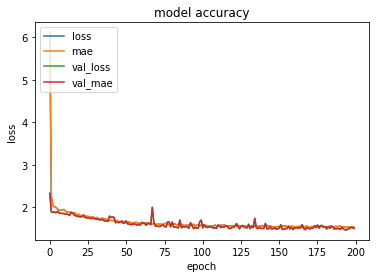

In [78]:
modelr = build_regression_model(train_rx, train_ry)

In [79]:
#預測test
pred_ry = modelr.predict(test_rx)
pred_ry = pred_ry.flatten()
#預測train
pred_train_ry = modelr.predict(train_rx)
pred_train_ry = pred_train_ry.flatten()

In [80]:
train_ry2 = train_ry.copy()
train_ry2 = train_ry2.values
train_ry2 = [float(train_ry2[i]) for i in range(len(train_ry2))]
#數值預測指標結果
mae = mean_absolute_error(test_ry, pred_ry)
mape = mean_absolute_percentage_error(test_ry, pred_ry)
rmse = root_mean_squared_error(test_ry, pred_ry)
print(f'test predict: mae:{mae}, mape:{mape}, rmse:{rmse}')


#數值預測指標train結果
mae_train = mean_absolute_error(train_ry2, pred_train_ry)
mape_train = mean_absolute_percentage_error(train_ry2, pred_train_ry)
rmse_train = root_mean_squared_error(train_ry2, pred_train_ry)
print(f'train predict: mae:{mae_train}, mape:{mape_train}, rmse:{rmse_train}')



test predict: mae:1.4901602671058218, mape:14.525108337402344, rmse:2.154870090462233
train predict: mae:1.4847108856626694, mape:14.351107597351074, rmse:2.1697676794023573


# 預測classification

In [81]:
#調參用模型
def talos_best(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=params['optimizer'], metrics = ['accuracy',recall_m,precision_m,f1_m])

    out = model.fit(x_train, y_train,
                              epochs=params['epochs'],  
                              batch_size=params['batch_size'],
                              validation_data=(x_val, y_val))
    return out,model

#預測結果模型
def build_classification_model(x, y):

    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001), metrics = ['accuracy',recall_m,precision_m,f1_m])

    
    model_result = model.fit(x, y,
                              epochs=200,  
                              batch_size=32,
                              validation_split=0.33)
    score = model.evaluate(x, y, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    plt.plot(model_result.history['accuracy'])
    plt.plot(model_result.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left') 
    plt.show()
    return model


In [54]:
#2進位資料轉換
test_cy = to_categorical(test_cy)
train_cy = to_categorical(train_cy)

classification_y =  to_categorical(classification_y)

In [55]:
train_cx = train_cx.to_numpy()

In [59]:
#搜尋參數
p = {'optimizer': ['SGD', 'Adam'],
     'batch_size': [32,64],
     'epochs':[200,300]
    }

scan_object = talos.Scan(train_cx, train_cy, model=talos_best, params=p, experiment_name='123')

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Epoch 1/200
62/62 [==============================] - 1s 7ms/step - loss: 1.1618 - accuracy: 0.3372 - recall_m: 0.0629 - precision_m: 0.3244 - f1_m: 0.1018 - val_loss: 1.0922 - val_accuracy: 0.3548 - val_recall_m: 0.0382 - val_precision_m: 0.4833 - val_f1_m: 0.0699
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.0900 - accuracy: 0.3582 - recall_m: 0.0444 - precision_m: 0.3849 - f1_m: 0.0763 - val_loss: 1.0843 - val_accuracy: 0.3548 - val_recall_m: 0.0231 - val_precision_m: 0.4000 - val_f1_m: 0.0430
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.0809 - accuracy: 0.3756 - recall_m: 0.0149 - precision_m: 0.2684 - f1_m: 0.0279 - val_loss: 1.0731 - val_accuracy: 0.3571 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.0650 - accuracy: 0.4029 - recall_m: 0.0304 - precision_m: 0.3702 - f1_m: 0.0544 - val_loss: 1.0715 - val_accuracy: 0.3

Epoch 32/200
62/62 [==============================] - 0s 2ms/step - loss: 0.9128 - accuracy: 0.5111 - recall_m: 0.2613 - precision_m: 0.6373 - f1_m: 0.3652 - val_loss: 0.9143 - val_accuracy: 0.5012 - val_recall_m: 0.2222 - val_precision_m: 0.6476 - val_f1_m: 0.3261
Epoch 33/200
62/62 [==============================] - 0s 2ms/step - loss: 0.9204 - accuracy: 0.5090 - recall_m: 0.2701 - precision_m: 0.6216 - f1_m: 0.3725 - val_loss: 1.0083 - val_accuracy: 0.4857 - val_recall_m: 0.2280 - val_precision_m: 0.5267 - val_f1_m: 0.3154
Epoch 34/200
62/62 [==============================] - 0s 2ms/step - loss: 0.9317 - accuracy: 0.5104 - recall_m: 0.2528 - precision_m: 0.6293 - f1_m: 0.3558 - val_loss: 0.9951 - val_accuracy: 0.4726 - val_recall_m: 0.1817 - val_precision_m: 0.6092 - val_f1_m: 0.2759
Epoch 35/200
62/62 [==============================] - 0s 2ms/step - loss: 0.9038 - accuracy: 0.5337 - recall_m: 0.2779 - precision_m: 0.6332 - f1_m: 0.3814 - val_loss: 0.9459 - val_accuracy: 0.4845 - va

Epoch 63/200
62/62 [==============================] - 0s 2ms/step - loss: 0.9087 - accuracy: 0.5309 - recall_m: 0.3146 - precision_m: 0.6413 - f1_m: 0.4192 - val_loss: 0.9393 - val_accuracy: 0.4952 - val_recall_m: 0.2685 - val_precision_m: 0.5861 - val_f1_m: 0.3652
Epoch 64/200
62/62 [==============================] - 0s 2ms/step - loss: 0.9241 - accuracy: 0.5127 - recall_m: 0.2879 - precision_m: 0.5921 - f1_m: 0.3840 - val_loss: 0.9141 - val_accuracy: 0.5250 - val_recall_m: 0.2743 - val_precision_m: 0.6095 - val_f1_m: 0.3742
Epoch 65/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8913 - accuracy: 0.5263 - recall_m: 0.3217 - precision_m: 0.6288 - f1_m: 0.4228 - val_loss: 0.9742 - val_accuracy: 0.4881 - val_recall_m: 0.3935 - val_precision_m: 0.5290 - val_f1_m: 0.4504
Epoch 66/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8773 - accuracy: 0.5214 - recall_m: 0.3088 - precision_m: 0.6015 - f1_m: 0.4040 - val_loss: 0.9129 - val_accuracy: 0.5107 - va

Epoch 94/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8803 - accuracy: 0.5421 - recall_m: 0.3444 - precision_m: 0.6420 - f1_m: 0.4460 - val_loss: 0.9075 - val_accuracy: 0.5119 - val_recall_m: 0.2176 - val_precision_m: 0.6734 - val_f1_m: 0.3230
Epoch 95/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8738 - accuracy: 0.5239 - recall_m: 0.3081 - precision_m: 0.6348 - f1_m: 0.4098 - val_loss: 0.8950 - val_accuracy: 0.5155 - val_recall_m: 0.2894 - val_precision_m: 0.6107 - val_f1_m: 0.3886
Epoch 96/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8721 - accuracy: 0.5492 - recall_m: 0.3095 - precision_m: 0.6507 - f1_m: 0.4157 - val_loss: 0.9765 - val_accuracy: 0.4881 - val_recall_m: 0.2766 - val_precision_m: 0.5908 - val_f1_m: 0.3735
Epoch 97/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8727 - accuracy: 0.5427 - recall_m: 0.3125 - precision_m: 0.6589 - f1_m: 0.4186 - val_loss: 0.9236 - val_accuracy: 0.5024 - va

Epoch 125/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8857 - accuracy: 0.5160 - recall_m: 0.3026 - precision_m: 0.6004 - f1_m: 0.3997 - val_loss: 0.8929 - val_accuracy: 0.5190 - val_recall_m: 0.2558 - val_precision_m: 0.6255 - val_f1_m: 0.3571
Epoch 126/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8672 - accuracy: 0.5355 - recall_m: 0.3167 - precision_m: 0.6486 - f1_m: 0.4222 - val_loss: 0.9831 - val_accuracy: 0.5012 - val_recall_m: 0.2523 - val_precision_m: 0.5917 - val_f1_m: 0.3502
Epoch 127/200
62/62 [==============================] - 0s 2ms/step - loss: 0.9018 - accuracy: 0.5282 - recall_m: 0.2746 - precision_m: 0.6076 - f1_m: 0.3730 - val_loss: 0.9199 - val_accuracy: 0.5226 - val_recall_m: 0.2558 - val_precision_m: 0.6158 - val_f1_m: 0.3579
Epoch 128/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8780 - accuracy: 0.5362 - recall_m: 0.2890 - precision_m: 0.6355 - f1_m: 0.3937 - val_loss: 1.2044 - val_accuracy: 0.4048 

Epoch 156/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8766 - accuracy: 0.5285 - recall_m: 0.3251 - precision_m: 0.6106 - f1_m: 0.4219 - val_loss: 0.9012 - val_accuracy: 0.5095 - val_recall_m: 0.3171 - val_precision_m: 0.5814 - val_f1_m: 0.4067
Epoch 157/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8888 - accuracy: 0.5260 - recall_m: 0.3118 - precision_m: 0.6297 - f1_m: 0.4143 - val_loss: 1.0422 - val_accuracy: 0.4750 - val_recall_m: 0.3056 - val_precision_m: 0.5252 - val_f1_m: 0.3844
Epoch 158/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8748 - accuracy: 0.5440 - recall_m: 0.3084 - precision_m: 0.6249 - f1_m: 0.4094 - val_loss: 0.9012 - val_accuracy: 0.5262 - val_recall_m: 0.3229 - val_precision_m: 0.5819 - val_f1_m: 0.4124
Epoch 159/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8793 - accuracy: 0.5066 - recall_m: 0.3075 - precision_m: 0.6147 - f1_m: 0.4072 - val_loss: 0.8929 - val_accuracy: 0.5202 

Epoch 187/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8970 - accuracy: 0.5219 - recall_m: 0.2757 - precision_m: 0.6035 - f1_m: 0.3737 - val_loss: 0.8950 - val_accuracy: 0.5226 - val_recall_m: 0.2986 - val_precision_m: 0.5984 - val_f1_m: 0.3953
Epoch 188/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8712 - accuracy: 0.5386 - recall_m: 0.3212 - precision_m: 0.6425 - f1_m: 0.4253 - val_loss: 0.9164 - val_accuracy: 0.5036 - val_recall_m: 0.2338 - val_precision_m: 0.6222 - val_f1_m: 0.3351
Epoch 189/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8810 - accuracy: 0.5325 - recall_m: 0.2945 - precision_m: 0.6350 - f1_m: 0.4004 - val_loss: 0.8914 - val_accuracy: 0.5190 - val_recall_m: 0.3148 - val_precision_m: 0.5910 - val_f1_m: 0.4081
Epoch 190/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8455 - accuracy: 0.5498 - recall_m: 0.3449 - precision_m: 0.6590 - f1_m: 0.4492 - val_loss: 0.9039 - val_accuracy: 0.5095 

 12%|██████████▌                                                                         | 1/8 [00:26<03:04, 26.35s/it]

Epoch 1/200
62/62 [==============================] - 1s 6ms/step - loss: 1.2161 - accuracy: 0.3268 - recall_m: 0.1386 - precision_m: 0.3289 - f1_m: 0.1799 - val_loss: 1.0737 - val_accuracy: 0.3548 - val_recall_m: 0.0012 - val_precision_m: 0.0370 - val_f1_m: 0.0022
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.0787 - accuracy: 0.3595 - recall_m: 0.0229 - precision_m: 0.3551 - f1_m: 0.0425 - val_loss: 1.0417 - val_accuracy: 0.3881 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.0332 - accuracy: 0.4413 - recall_m: 0.0227 - precision_m: 0.3143 - f1_m: 0.0415 - val_loss: 0.9901 - val_accuracy: 0.4786 - val_recall_m: 0.0150 - val_precision_m: 0.3580 - val_f1_m: 0.0287
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.9752 - accuracy: 0.4948 - recall_m: 0.1056 - precision_m: 0.5445 - f1_m: 0.1700 - val_loss: 0.9401 - val_accuracy: 0.5

Epoch 32/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8554 - accuracy: 0.5493 - recall_m: 0.3438 - precision_m: 0.6551 - f1_m: 0.4443 - val_loss: 0.9126 - val_accuracy: 0.5226 - val_recall_m: 0.4144 - val_precision_m: 0.5653 - val_f1_m: 0.4769
Epoch 33/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8758 - accuracy: 0.5425 - recall_m: 0.3623 - precision_m: 0.6157 - f1_m: 0.4511 - val_loss: 0.8872 - val_accuracy: 0.5179 - val_recall_m: 0.2627 - val_precision_m: 0.6192 - val_f1_m: 0.3635
Epoch 34/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8708 - accuracy: 0.5351 - recall_m: 0.3214 - precision_m: 0.6713 - f1_m: 0.4316 - val_loss: 0.8938 - val_accuracy: 0.5131 - val_recall_m: 0.3495 - val_precision_m: 0.5736 - val_f1_m: 0.4317
Epoch 35/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8591 - accuracy: 0.5344 - recall_m: 0.3105 - precision_m: 0.6150 - f1_m: 0.4101 - val_loss: 0.8854 - val_accuracy: 0.5262 - va

Epoch 63/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8417 - accuracy: 0.5474 - recall_m: 0.3468 - precision_m: 0.6154 - f1_m: 0.4409 - val_loss: 0.8747 - val_accuracy: 0.5179 - val_recall_m: 0.3125 - val_precision_m: 0.6069 - val_f1_m: 0.4084
Epoch 64/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8580 - accuracy: 0.5542 - recall_m: 0.3457 - precision_m: 0.6446 - f1_m: 0.4478 - val_loss: 0.8751 - val_accuracy: 0.5381 - val_recall_m: 0.2731 - val_precision_m: 0.6621 - val_f1_m: 0.3816
Epoch 65/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8195 - accuracy: 0.5715 - recall_m: 0.3978 - precision_m: 0.6661 - f1_m: 0.4906 - val_loss: 0.8738 - val_accuracy: 0.5286 - val_recall_m: 0.2361 - val_precision_m: 0.6946 - val_f1_m: 0.3458
Epoch 66/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8477 - accuracy: 0.5524 - recall_m: 0.3071 - precision_m: 0.6746 - f1_m: 0.4170 - val_loss: 0.8761 - val_accuracy: 0.5214 - va

Epoch 94/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8578 - accuracy: 0.5442 - recall_m: 0.3574 - precision_m: 0.6413 - f1_m: 0.4569 - val_loss: 0.8709 - val_accuracy: 0.5286 - val_recall_m: 0.3056 - val_precision_m: 0.6218 - val_f1_m: 0.4056
Epoch 95/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8293 - accuracy: 0.5510 - recall_m: 0.3306 - precision_m: 0.6470 - f1_m: 0.4361 - val_loss: 0.8695 - val_accuracy: 0.5262 - val_recall_m: 0.2639 - val_precision_m: 0.6463 - val_f1_m: 0.3703
Epoch 96/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8658 - accuracy: 0.5350 - recall_m: 0.3146 - precision_m: 0.6529 - f1_m: 0.4213 - val_loss: 0.8726 - val_accuracy: 0.5286 - val_recall_m: 0.3819 - val_precision_m: 0.5942 - val_f1_m: 0.4626
Epoch 97/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8746 - accuracy: 0.5411 - recall_m: 0.3383 - precision_m: 0.6447 - f1_m: 0.4401 - val_loss: 0.8710 - val_accuracy: 0.5310 - va

Epoch 125/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8376 - accuracy: 0.5234 - recall_m: 0.3343 - precision_m: 0.6261 - f1_m: 0.4334 - val_loss: 0.8711 - val_accuracy: 0.5321 - val_recall_m: 0.3322 - val_precision_m: 0.6128 - val_f1_m: 0.4278
Epoch 126/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8276 - accuracy: 0.5778 - recall_m: 0.3677 - precision_m: 0.6739 - f1_m: 0.4734 - val_loss: 0.8688 - val_accuracy: 0.5250 - val_recall_m: 0.2998 - val_precision_m: 0.6253 - val_f1_m: 0.4012
Epoch 127/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8559 - accuracy: 0.5522 - recall_m: 0.3204 - precision_m: 0.6543 - f1_m: 0.4261 - val_loss: 0.8710 - val_accuracy: 0.5310 - val_recall_m: 0.2558 - val_precision_m: 0.6680 - val_f1_m: 0.3656
Epoch 128/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8693 - accuracy: 0.5371 - recall_m: 0.3508 - precision_m: 0.6590 - f1_m: 0.4554 - val_loss: 0.8759 - val_accuracy: 0.5226 

Epoch 156/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8448 - accuracy: 0.5597 - recall_m: 0.3705 - precision_m: 0.6440 - f1_m: 0.4671 - val_loss: 0.8648 - val_accuracy: 0.5321 - val_recall_m: 0.3218 - val_precision_m: 0.5982 - val_f1_m: 0.4150
Epoch 157/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8494 - accuracy: 0.5441 - recall_m: 0.3205 - precision_m: 0.6392 - f1_m: 0.4232 - val_loss: 0.8672 - val_accuracy: 0.5226 - val_recall_m: 0.3484 - val_precision_m: 0.5898 - val_f1_m: 0.4350
Epoch 158/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8300 - accuracy: 0.5571 - recall_m: 0.3570 - precision_m: 0.6675 - f1_m: 0.4620 - val_loss: 0.8656 - val_accuracy: 0.5214 - val_recall_m: 0.3125 - val_precision_m: 0.6203 - val_f1_m: 0.4114
Epoch 159/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8260 - accuracy: 0.5668 - recall_m: 0.3548 - precision_m: 0.6575 - f1_m: 0.4578 - val_loss: 0.8637 - val_accuracy: 0.5310 

Epoch 187/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8245 - accuracy: 0.5654 - recall_m: 0.3142 - precision_m: 0.6577 - f1_m: 0.4224 - val_loss: 0.8616 - val_accuracy: 0.5333 - val_recall_m: 0.2894 - val_precision_m: 0.6456 - val_f1_m: 0.3945
Epoch 188/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8259 - accuracy: 0.5711 - recall_m: 0.3403 - precision_m: 0.6745 - f1_m: 0.4494 - val_loss: 0.8633 - val_accuracy: 0.5298 - val_recall_m: 0.3113 - val_precision_m: 0.6483 - val_f1_m: 0.4162
Epoch 189/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8277 - accuracy: 0.5702 - recall_m: 0.3465 - precision_m: 0.6531 - f1_m: 0.4505 - val_loss: 0.8590 - val_accuracy: 0.5357 - val_recall_m: 0.2801 - val_precision_m: 0.6732 - val_f1_m: 0.3907
Epoch 190/200
62/62 [==============================] - 0s 2ms/step - loss: 0.8125 - accuracy: 0.5663 - recall_m: 0.3526 - precision_m: 0.6761 - f1_m: 0.4587 - val_loss: 0.8688 - val_accuracy: 0.5107 

 25%|█████████████████████                                                               | 2/8 [00:54<02:41, 26.88s/it]

Epoch 1/300
62/62 [==============================] - 1s 6ms/step - loss: 1.1234 - accuracy: 0.3286 - recall_m: 0.0533 - precision_m: 0.4533 - f1_m: 0.0922 - val_loss: 1.1023 - val_accuracy: 0.3548 - val_recall_m: 0.0833 - val_precision_m: 0.4110 - val_f1_m: 0.1371
Epoch 2/300
62/62 [==============================] - 0s 2ms/step - loss: 1.0941 - accuracy: 0.3554 - recall_m: 0.0347 - precision_m: 0.4006 - f1_m: 0.0617 - val_loss: 1.0889 - val_accuracy: 0.3548 - val_recall_m: 0.0370 - val_precision_m: 0.4710 - val_f1_m: 0.0679
Epoch 3/300
62/62 [==============================] - 0s 2ms/step - loss: 1.0827 - accuracy: 0.3614 - recall_m: 0.0207 - precision_m: 0.2830 - f1_m: 0.0378 - val_loss: 1.0741 - val_accuracy: 0.3524 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/300
62/62 [==============================] - 0s 2ms/step - loss: 1.0747 - accuracy: 0.3510 - recall_m: 0.0100 - precision_m: 0.2466 - f1_m: 0.0190 - val_loss: 1.0709 - val_accuracy: 0.3

Epoch 32/300
62/62 [==============================] - 0s 2ms/step - loss: 0.9537 - accuracy: 0.5242 - recall_m: 0.2269 - precision_m: 0.6637 - f1_m: 0.3346 - val_loss: 0.9475 - val_accuracy: 0.5036 - val_recall_m: 0.2674 - val_precision_m: 0.6006 - val_f1_m: 0.3668
Epoch 33/300
62/62 [==============================] - 0s 2ms/step - loss: 0.9593 - accuracy: 0.4961 - recall_m: 0.2264 - precision_m: 0.6388 - f1_m: 0.3311 - val_loss: 0.9498 - val_accuracy: 0.4940 - val_recall_m: 0.2338 - val_precision_m: 0.6133 - val_f1_m: 0.3356
Epoch 34/300
62/62 [==============================] - 0s 2ms/step - loss: 0.9446 - accuracy: 0.5195 - recall_m: 0.2107 - precision_m: 0.6679 - f1_m: 0.3145 - val_loss: 0.9454 - val_accuracy: 0.4964 - val_recall_m: 0.1493 - val_precision_m: 0.7163 - val_f1_m: 0.2427
Epoch 35/300
62/62 [==============================] - 0s 2ms/step - loss: 0.9052 - accuracy: 0.5401 - recall_m: 0.2631 - precision_m: 0.6981 - f1_m: 0.3768 - val_loss: 1.2995 - val_accuracy: 0.3179 - va

Epoch 63/300
62/62 [==============================] - 0s 2ms/step - loss: 0.9110 - accuracy: 0.5095 - recall_m: 0.3312 - precision_m: 0.6042 - f1_m: 0.4242 - val_loss: 1.1179 - val_accuracy: 0.4524 - val_recall_m: 0.3530 - val_precision_m: 0.4622 - val_f1_m: 0.3993
Epoch 64/300
62/62 [==============================] - 0s 2ms/step - loss: 0.9091 - accuracy: 0.5279 - recall_m: 0.3282 - precision_m: 0.6196 - f1_m: 0.4265 - val_loss: 0.9215 - val_accuracy: 0.5286 - val_recall_m: 0.3044 - val_precision_m: 0.5946 - val_f1_m: 0.3990
Epoch 65/300
62/62 [==============================] - 0s 2ms/step - loss: 0.9042 - accuracy: 0.5140 - recall_m: 0.3074 - precision_m: 0.5939 - f1_m: 0.4023 - val_loss: 0.9948 - val_accuracy: 0.4786 - val_recall_m: 0.3657 - val_precision_m: 0.5119 - val_f1_m: 0.4259
Epoch 66/300
62/62 [==============================] - 0s 2ms/step - loss: 0.9084 - accuracy: 0.5080 - recall_m: 0.3079 - precision_m: 0.6005 - f1_m: 0.4038 - val_loss: 1.0323 - val_accuracy: 0.4631 - va

Epoch 94/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8783 - accuracy: 0.5586 - recall_m: 0.3248 - precision_m: 0.6511 - f1_m: 0.4281 - val_loss: 0.9038 - val_accuracy: 0.5155 - val_recall_m: 0.2662 - val_precision_m: 0.6080 - val_f1_m: 0.3658
Epoch 95/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8865 - accuracy: 0.5191 - recall_m: 0.3024 - precision_m: 0.6052 - f1_m: 0.4007 - val_loss: 0.9014 - val_accuracy: 0.5155 - val_recall_m: 0.3773 - val_precision_m: 0.5622 - val_f1_m: 0.4492
Epoch 96/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8739 - accuracy: 0.5370 - recall_m: 0.3449 - precision_m: 0.6240 - f1_m: 0.4412 - val_loss: 0.9088 - val_accuracy: 0.5095 - val_recall_m: 0.3854 - val_precision_m: 0.5565 - val_f1_m: 0.4534
Epoch 97/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8774 - accuracy: 0.5419 - recall_m: 0.3307 - precision_m: 0.6341 - f1_m: 0.4311 - val_loss: 0.9326 - val_accuracy: 0.5107 - va

Epoch 125/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8702 - accuracy: 0.5482 - recall_m: 0.3216 - precision_m: 0.6121 - f1_m: 0.4191 - val_loss: 0.9582 - val_accuracy: 0.4893 - val_recall_m: 0.2569 - val_precision_m: 0.6070 - val_f1_m: 0.3579
Epoch 126/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8635 - accuracy: 0.5504 - recall_m: 0.3185 - precision_m: 0.6405 - f1_m: 0.4226 - val_loss: 0.8960 - val_accuracy: 0.5179 - val_recall_m: 0.3530 - val_precision_m: 0.5684 - val_f1_m: 0.4324
Epoch 127/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8706 - accuracy: 0.5350 - recall_m: 0.3267 - precision_m: 0.6185 - f1_m: 0.4253 - val_loss: 0.8955 - val_accuracy: 0.5202 - val_recall_m: 0.3692 - val_precision_m: 0.5618 - val_f1_m: 0.4433
Epoch 128/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8623 - accuracy: 0.5485 - recall_m: 0.3511 - precision_m: 0.6368 - f1_m: 0.4484 - val_loss: 0.9186 - val_accuracy: 0.5202 

Epoch 156/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8683 - accuracy: 0.5457 - recall_m: 0.3178 - precision_m: 0.6159 - f1_m: 0.4160 - val_loss: 0.9167 - val_accuracy: 0.4988 - val_recall_m: 0.2766 - val_precision_m: 0.6103 - val_f1_m: 0.3765
Epoch 157/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8672 - accuracy: 0.5501 - recall_m: 0.3137 - precision_m: 0.6558 - f1_m: 0.4202 - val_loss: 0.9699 - val_accuracy: 0.4810 - val_recall_m: 0.2697 - val_precision_m: 0.5663 - val_f1_m: 0.3626
Epoch 158/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8842 - accuracy: 0.5362 - recall_m: 0.2873 - precision_m: 0.6625 - f1_m: 0.3957 - val_loss: 0.8967 - val_accuracy: 0.5167 - val_recall_m: 0.3935 - val_precision_m: 0.5624 - val_f1_m: 0.4612
Epoch 159/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8696 - accuracy: 0.5379 - recall_m: 0.3377 - precision_m: 0.6456 - f1_m: 0.4386 - val_loss: 0.8979 - val_accuracy: 0.5143 

Epoch 187/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8650 - accuracy: 0.5381 - recall_m: 0.3077 - precision_m: 0.6408 - f1_m: 0.4125 - val_loss: 0.8932 - val_accuracy: 0.5214 - val_recall_m: 0.2917 - val_precision_m: 0.5993 - val_f1_m: 0.3887
Epoch 188/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8496 - accuracy: 0.5520 - recall_m: 0.3242 - precision_m: 0.6539 - f1_m: 0.4293 - val_loss: 0.8981 - val_accuracy: 0.5107 - val_recall_m: 0.3322 - val_precision_m: 0.5880 - val_f1_m: 0.4208
Epoch 189/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8782 - accuracy: 0.5324 - recall_m: 0.3059 - precision_m: 0.6636 - f1_m: 0.4153 - val_loss: 0.8981 - val_accuracy: 0.5179 - val_recall_m: 0.4039 - val_precision_m: 0.5584 - val_f1_m: 0.4670
Epoch 190/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8714 - accuracy: 0.5123 - recall_m: 0.3122 - precision_m: 0.6138 - f1_m: 0.4109 - val_loss: 0.9535 - val_accuracy: 0.4857 

Epoch 218/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8635 - accuracy: 0.5601 - recall_m: 0.3549 - precision_m: 0.6447 - f1_m: 0.4552 - val_loss: 0.8907 - val_accuracy: 0.5179 - val_recall_m: 0.3194 - val_precision_m: 0.5981 - val_f1_m: 0.4133
Epoch 219/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8825 - accuracy: 0.5359 - recall_m: 0.2933 - precision_m: 0.6446 - f1_m: 0.3997 - val_loss: 0.9242 - val_accuracy: 0.5095 - val_recall_m: 0.2743 - val_precision_m: 0.6089 - val_f1_m: 0.3745
Epoch 220/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8703 - accuracy: 0.5223 - recall_m: 0.2870 - precision_m: 0.6531 - f1_m: 0.3933 - val_loss: 0.9331 - val_accuracy: 0.5179 - val_recall_m: 0.3171 - val_precision_m: 0.5644 - val_f1_m: 0.4035
Epoch 221/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8672 - accuracy: 0.5367 - recall_m: 0.3133 - precision_m: 0.6175 - f1_m: 0.4130 - val_loss: 0.9317 - val_accuracy: 0.4893 

Epoch 249/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8586 - accuracy: 0.5406 - recall_m: 0.3229 - precision_m: 0.6562 - f1_m: 0.4281 - val_loss: 0.9100 - val_accuracy: 0.5048 - val_recall_m: 0.2986 - val_precision_m: 0.6005 - val_f1_m: 0.3954
Epoch 250/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8547 - accuracy: 0.5537 - recall_m: 0.3260 - precision_m: 0.6494 - f1_m: 0.4313 - val_loss: 0.9017 - val_accuracy: 0.5202 - val_recall_m: 0.2569 - val_precision_m: 0.6438 - val_f1_m: 0.3620
Epoch 251/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8776 - accuracy: 0.5373 - recall_m: 0.2927 - precision_m: 0.6588 - f1_m: 0.4019 - val_loss: 0.9016 - val_accuracy: 0.5167 - val_recall_m: 0.3866 - val_precision_m: 0.5619 - val_f1_m: 0.4557
Epoch 252/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8756 - accuracy: 0.5331 - recall_m: 0.3490 - precision_m: 0.6304 - f1_m: 0.4461 - val_loss: 0.9292 - val_accuracy: 0.5167 

Epoch 280/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8569 - accuracy: 0.5601 - recall_m: 0.2903 - precision_m: 0.6674 - f1_m: 0.4003 - val_loss: 0.8965 - val_accuracy: 0.5226 - val_recall_m: 0.2361 - val_precision_m: 0.6566 - val_f1_m: 0.3426
Epoch 281/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8516 - accuracy: 0.5354 - recall_m: 0.2848 - precision_m: 0.6679 - f1_m: 0.3952 - val_loss: 0.9145 - val_accuracy: 0.5274 - val_recall_m: 0.3160 - val_precision_m: 0.5764 - val_f1_m: 0.4056
Epoch 282/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8777 - accuracy: 0.5351 - recall_m: 0.3196 - precision_m: 0.6645 - f1_m: 0.4244 - val_loss: 0.8884 - val_accuracy: 0.5262 - val_recall_m: 0.3426 - val_precision_m: 0.5750 - val_f1_m: 0.4262
Epoch 283/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8570 - accuracy: 0.5607 - recall_m: 0.3485 - precision_m: 0.6569 - f1_m: 0.4524 - val_loss: 0.9080 - val_accuracy: 0.5036 

 38%|███████████████████████████████▌                                                    | 3/8 [01:33<02:32, 30.51s/it]

Epoch 1/300
62/62 [==============================] - 1s 7ms/step - loss: 1.1571 - accuracy: 0.3514 - recall_m: 0.1081 - precision_m: 0.3900 - f1_m: 0.1563 - val_loss: 1.0937 - val_accuracy: 0.3548 - val_recall_m: 0.1076 - val_precision_m: 0.4229 - val_f1_m: 0.1702
Epoch 2/300
62/62 [==============================] - 0s 2ms/step - loss: 1.0658 - accuracy: 0.3881 - recall_m: 0.0590 - precision_m: 0.3872 - f1_m: 0.0972 - val_loss: 1.0536 - val_accuracy: 0.4940 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/300
62/62 [==============================] - 0s 2ms/step - loss: 1.0413 - accuracy: 0.4416 - recall_m: 0.0345 - precision_m: 0.2948 - f1_m: 0.0595 - val_loss: 1.0047 - val_accuracy: 0.4964 - val_recall_m: 0.0069 - val_precision_m: 0.2037 - val_f1_m: 0.0134
Epoch 4/300
62/62 [==============================] - 0s 2ms/step - loss: 0.9950 - accuracy: 0.4877 - recall_m: 0.0781 - precision_m: 0.4786 - f1_m: 0.1302 - val_loss: 0.9560 - val_accuracy: 0.5

Epoch 32/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8723 - accuracy: 0.5362 - recall_m: 0.3433 - precision_m: 0.6146 - f1_m: 0.4371 - val_loss: 0.8844 - val_accuracy: 0.5190 - val_recall_m: 0.3310 - val_precision_m: 0.5784 - val_f1_m: 0.4171
Epoch 33/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8796 - accuracy: 0.5406 - recall_m: 0.3138 - precision_m: 0.6345 - f1_m: 0.4166 - val_loss: 0.8846 - val_accuracy: 0.5202 - val_recall_m: 0.3704 - val_precision_m: 0.5664 - val_f1_m: 0.4457
Epoch 34/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8537 - accuracy: 0.5436 - recall_m: 0.3323 - precision_m: 0.6274 - f1_m: 0.4317 - val_loss: 0.8856 - val_accuracy: 0.5238 - val_recall_m: 0.3322 - val_precision_m: 0.5822 - val_f1_m: 0.4198
Epoch 35/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8610 - accuracy: 0.5514 - recall_m: 0.3124 - precision_m: 0.6189 - f1_m: 0.4126 - val_loss: 0.8881 - val_accuracy: 0.5202 - va

62/62 [==============================] - 0s 2ms/step - loss: 0.8490 - accuracy: 0.5453 - recall_m: 0.3347 - precision_m: 0.6203 - f1_m: 0.4323 - val_loss: 0.8742 - val_accuracy: 0.5250 - val_recall_m: 0.3032 - val_precision_m: 0.6083 - val_f1_m: 0.4005
Epoch 63/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8319 - accuracy: 0.5720 - recall_m: 0.3741 - precision_m: 0.6517 - f1_m: 0.4703 - val_loss: 0.8719 - val_accuracy: 0.5286 - val_recall_m: 0.3218 - val_precision_m: 0.6080 - val_f1_m: 0.4173
Epoch 64/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8611 - accuracy: 0.5314 - recall_m: 0.3432 - precision_m: 0.6320 - f1_m: 0.4424 - val_loss: 0.8787 - val_accuracy: 0.5321 - val_recall_m: 0.3391 - val_precision_m: 0.5969 - val_f1_m: 0.4289
Epoch 65/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8547 - accuracy: 0.5310 - recall_m: 0.3085 - precision_m: 0.6237 - f1_m: 0.4093 - val_loss: 0.8728 - val_accuracy: 0.5274 - val_recall_m: 0

Epoch 93/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8277 - accuracy: 0.5610 - recall_m: 0.3731 - precision_m: 0.6498 - f1_m: 0.4700 - val_loss: 0.8702 - val_accuracy: 0.5345 - val_recall_m: 0.3125 - val_precision_m: 0.6095 - val_f1_m: 0.4095
Epoch 94/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8536 - accuracy: 0.5328 - recall_m: 0.2779 - precision_m: 0.6392 - f1_m: 0.3842 - val_loss: 0.8814 - val_accuracy: 0.5333 - val_recall_m: 0.3530 - val_precision_m: 0.5984 - val_f1_m: 0.4417
Epoch 95/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8491 - accuracy: 0.5577 - recall_m: 0.3720 - precision_m: 0.6412 - f1_m: 0.4680 - val_loss: 0.8654 - val_accuracy: 0.5298 - val_recall_m: 0.3090 - val_precision_m: 0.6161 - val_f1_m: 0.4074
Epoch 96/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8657 - accuracy: 0.5477 - recall_m: 0.3356 - precision_m: 0.6426 - f1_m: 0.4391 - val_loss: 0.8689 - val_accuracy: 0.5286 - va

Epoch 124/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8244 - accuracy: 0.5481 - recall_m: 0.3582 - precision_m: 0.6441 - f1_m: 0.4576 - val_loss: 0.8625 - val_accuracy: 0.5357 - val_recall_m: 0.3090 - val_precision_m: 0.6250 - val_f1_m: 0.4097
Epoch 125/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8463 - accuracy: 0.5542 - recall_m: 0.3037 - precision_m: 0.6488 - f1_m: 0.4121 - val_loss: 0.8657 - val_accuracy: 0.5333 - val_recall_m: 0.3241 - val_precision_m: 0.6034 - val_f1_m: 0.4184
Epoch 126/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8277 - accuracy: 0.5670 - recall_m: 0.3827 - precision_m: 0.6343 - f1_m: 0.4752 - val_loss: 0.8654 - val_accuracy: 0.5310 - val_recall_m: 0.2870 - val_precision_m: 0.6313 - val_f1_m: 0.3897
Epoch 127/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8332 - accuracy: 0.5620 - recall_m: 0.3413 - precision_m: 0.6671 - f1_m: 0.4480 - val_loss: 0.8660 - val_accuracy: 0.5286 

Epoch 155/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8372 - accuracy: 0.5592 - recall_m: 0.3513 - precision_m: 0.6722 - f1_m: 0.4592 - val_loss: 0.8620 - val_accuracy: 0.5405 - val_recall_m: 0.2627 - val_precision_m: 0.7007 - val_f1_m: 0.3775
Epoch 156/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8455 - accuracy: 0.5555 - recall_m: 0.3341 - precision_m: 0.6671 - f1_m: 0.4421 - val_loss: 0.8637 - val_accuracy: 0.5476 - val_recall_m: 0.2824 - val_precision_m: 0.6646 - val_f1_m: 0.3916
Epoch 157/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8136 - accuracy: 0.5795 - recall_m: 0.3666 - precision_m: 0.6574 - f1_m: 0.4681 - val_loss: 0.8685 - val_accuracy: 0.5345 - val_recall_m: 0.2801 - val_precision_m: 0.6547 - val_f1_m: 0.3874
Epoch 158/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8358 - accuracy: 0.5604 - recall_m: 0.3337 - precision_m: 0.6647 - f1_m: 0.4408 - val_loss: 0.8635 - val_accuracy: 0.5286 

Epoch 186/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8167 - accuracy: 0.5836 - recall_m: 0.3683 - precision_m: 0.6851 - f1_m: 0.4747 - val_loss: 0.8614 - val_accuracy: 0.5333 - val_recall_m: 0.2338 - val_precision_m: 0.6759 - val_f1_m: 0.3407
Epoch 187/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8313 - accuracy: 0.5446 - recall_m: 0.3232 - precision_m: 0.6782 - f1_m: 0.4342 - val_loss: 0.8673 - val_accuracy: 0.5429 - val_recall_m: 0.3044 - val_precision_m: 0.6244 - val_f1_m: 0.4059
Epoch 188/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8453 - accuracy: 0.5663 - recall_m: 0.3934 - precision_m: 0.6474 - f1_m: 0.4865 - val_loss: 0.8623 - val_accuracy: 0.5274 - val_recall_m: 0.2523 - val_precision_m: 0.6603 - val_f1_m: 0.3592
Epoch 189/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8518 - accuracy: 0.5377 - recall_m: 0.2983 - precision_m: 0.6636 - f1_m: 0.4086 - val_loss: 0.8622 - val_accuracy: 0.5464 

Epoch 217/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8327 - accuracy: 0.5552 - recall_m: 0.3591 - precision_m: 0.6427 - f1_m: 0.4582 - val_loss: 0.8588 - val_accuracy: 0.5393 - val_recall_m: 0.2766 - val_precision_m: 0.6622 - val_f1_m: 0.3850
Epoch 218/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8577 - accuracy: 0.5373 - recall_m: 0.3075 - precision_m: 0.6334 - f1_m: 0.4109 - val_loss: 0.8611 - val_accuracy: 0.5333 - val_recall_m: 0.2708 - val_precision_m: 0.6522 - val_f1_m: 0.3770
Epoch 219/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8310 - accuracy: 0.5635 - recall_m: 0.3251 - precision_m: 0.6641 - f1_m: 0.4331 - val_loss: 0.8605 - val_accuracy: 0.5417 - val_recall_m: 0.2963 - val_precision_m: 0.6305 - val_f1_m: 0.3997
Epoch 220/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8361 - accuracy: 0.5619 - recall_m: 0.3778 - precision_m: 0.6636 - f1_m: 0.4781 - val_loss: 0.8572 - val_accuracy: 0.5405 

Epoch 248/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8191 - accuracy: 0.5572 - recall_m: 0.3679 - precision_m: 0.6401 - f1_m: 0.4645 - val_loss: 0.8674 - val_accuracy: 0.5238 - val_recall_m: 0.2731 - val_precision_m: 0.6496 - val_f1_m: 0.3797
Epoch 249/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8316 - accuracy: 0.5670 - recall_m: 0.3222 - precision_m: 0.6790 - f1_m: 0.4340 - val_loss: 0.8625 - val_accuracy: 0.5417 - val_recall_m: 0.2789 - val_precision_m: 0.6393 - val_f1_m: 0.3831
Epoch 250/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8285 - accuracy: 0.5644 - recall_m: 0.3185 - precision_m: 0.6578 - f1_m: 0.4253 - val_loss: 0.8601 - val_accuracy: 0.5393 - val_recall_m: 0.2940 - val_precision_m: 0.6631 - val_f1_m: 0.4030
Epoch 251/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8297 - accuracy: 0.5504 - recall_m: 0.3467 - precision_m: 0.6729 - f1_m: 0.4541 - val_loss: 0.8648 - val_accuracy: 0.5167 

Epoch 279/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8208 - accuracy: 0.5580 - recall_m: 0.3635 - precision_m: 0.6514 - f1_m: 0.4642 - val_loss: 0.8939 - val_accuracy: 0.5405 - val_recall_m: 0.3009 - val_precision_m: 0.6268 - val_f1_m: 0.4026
Epoch 280/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8443 - accuracy: 0.5613 - recall_m: 0.3287 - precision_m: 0.6853 - f1_m: 0.4418 - val_loss: 0.8617 - val_accuracy: 0.5417 - val_recall_m: 0.3287 - val_precision_m: 0.6158 - val_f1_m: 0.4257
Epoch 281/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8235 - accuracy: 0.5488 - recall_m: 0.3695 - precision_m: 0.6492 - f1_m: 0.4687 - val_loss: 0.8722 - val_accuracy: 0.5381 - val_recall_m: 0.2882 - val_precision_m: 0.6504 - val_f1_m: 0.3951
Epoch 282/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8474 - accuracy: 0.5623 - recall_m: 0.3372 - precision_m: 0.6694 - f1_m: 0.4452 - val_loss: 0.8814 - val_accuracy: 0.5452 

 50%|██████████████████████████████████████████                                          | 4/8 [02:15<02:15, 33.90s/it]

Epoch 1/200
31/31 [==============================] - 1s 12ms/step - loss: 1.1555 - accuracy: 0.3228 - recall_m: 0.0465 - precision_m: 0.3606 - f1_m: 0.0808 - val_loss: 1.0948 - val_accuracy: 0.3548 - val_recall_m: 0.0402 - val_precision_m: 0.4558 - val_f1_m: 0.0735
Epoch 2/200
31/31 [==============================] - 0s 3ms/step - loss: 1.1022 - accuracy: 0.3714 - recall_m: 0.0697 - precision_m: 0.4213 - f1_m: 0.1173 - val_loss: 1.0932 - val_accuracy: 0.3548 - val_recall_m: 0.0413 - val_precision_m: 0.4622 - val_f1_m: 0.0754
Epoch 3/200
31/31 [==============================] - 0s 3ms/step - loss: 1.0854 - accuracy: 0.3612 - recall_m: 0.0400 - precision_m: 0.4080 - f1_m: 0.0713 - val_loss: 1.0866 - val_accuracy: 0.3548 - val_recall_m: 0.0246 - val_precision_m: 0.4714 - val_f1_m: 0.0462
Epoch 4/200
31/31 [==============================] - 0s 3ms/step - loss: 1.0838 - accuracy: 0.3695 - recall_m: 0.0462 - precision_m: 0.4920 - f1_m: 0.0833 - val_loss: 1.0773 - val_accuracy: 0.3560 - val_r

31/31 [==============================] - 0s 3ms/step - loss: 0.9664 - accuracy: 0.5153 - recall_m: 0.1270 - precision_m: 0.6333 - f1_m: 0.2101 - val_loss: 0.9647 - val_accuracy: 0.5119 - val_recall_m: 0.1529 - val_precision_m: 0.7536 - val_f1_m: 0.2519
Epoch 32/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9650 - accuracy: 0.5106 - recall_m: 0.1486 - precision_m: 0.7105 - f1_m: 0.2437 - val_loss: 0.9593 - val_accuracy: 0.5131 - val_recall_m: 0.1540 - val_precision_m: 0.7364 - val_f1_m: 0.2521
Epoch 33/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9733 - accuracy: 0.5095 - recall_m: 0.1395 - precision_m: 0.6972 - f1_m: 0.2312 - val_loss: 0.9558 - val_accuracy: 0.5060 - val_recall_m: 0.1696 - val_precision_m: 0.5947 - val_f1_m: 0.2622
Epoch 34/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9695 - accuracy: 0.5041 - recall_m: 0.1448 - precision_m: 0.6532 - f1_m: 0.2349 - val_loss: 0.9558 - val_accuracy: 0.5143 - val_recall_m: 0

Epoch 62/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9074 - accuracy: 0.5254 - recall_m: 0.2771 - precision_m: 0.6159 - f1_m: 0.3802 - val_loss: 0.9130 - val_accuracy: 0.5167 - val_recall_m: 0.2779 - val_precision_m: 0.5914 - val_f1_m: 0.3754
Epoch 63/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9066 - accuracy: 0.5409 - recall_m: 0.2835 - precision_m: 0.6580 - f1_m: 0.3942 - val_loss: 0.9232 - val_accuracy: 0.4976 - val_recall_m: 0.3292 - val_precision_m: 0.5477 - val_f1_m: 0.4104
Epoch 64/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9143 - accuracy: 0.5443 - recall_m: 0.2984 - precision_m: 0.6337 - f1_m: 0.4048 - val_loss: 0.9162 - val_accuracy: 0.5071 - val_recall_m: 0.2879 - val_precision_m: 0.5869 - val_f1_m: 0.3831
Epoch 65/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9079 - accuracy: 0.5249 - recall_m: 0.2630 - precision_m: 0.6351 - f1_m: 0.3702 - val_loss: 0.9155 - val_accuracy: 0.5083 - va

Epoch 93/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9114 - accuracy: 0.5347 - recall_m: 0.3198 - precision_m: 0.6209 - f1_m: 0.4183 - val_loss: 0.9755 - val_accuracy: 0.5012 - val_recall_m: 0.3270 - val_precision_m: 0.5536 - val_f1_m: 0.4097
Epoch 94/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8932 - accuracy: 0.5424 - recall_m: 0.3310 - precision_m: 0.6195 - f1_m: 0.4302 - val_loss: 0.9056 - val_accuracy: 0.5131 - val_recall_m: 0.3248 - val_precision_m: 0.5545 - val_f1_m: 0.4077
Epoch 95/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8845 - accuracy: 0.5276 - recall_m: 0.3097 - precision_m: 0.6285 - f1_m: 0.4139 - val_loss: 0.9146 - val_accuracy: 0.5262 - val_recall_m: 0.3170 - val_precision_m: 0.5640 - val_f1_m: 0.4040
Epoch 96/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9084 - accuracy: 0.5028 - recall_m: 0.2828 - precision_m: 0.5900 - f1_m: 0.3807 - val_loss: 0.9448 - val_accuracy: 0.5119 - va

Epoch 124/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8937 - accuracy: 0.5307 - recall_m: 0.3091 - precision_m: 0.6216 - f1_m: 0.4111 - val_loss: 0.9061 - val_accuracy: 0.5107 - val_recall_m: 0.3337 - val_precision_m: 0.5429 - val_f1_m: 0.4118
Epoch 125/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8641 - accuracy: 0.5554 - recall_m: 0.3152 - precision_m: 0.6540 - f1_m: 0.4239 - val_loss: 0.9289 - val_accuracy: 0.5083 - val_recall_m: 0.3650 - val_precision_m: 0.5478 - val_f1_m: 0.4370
Epoch 126/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8801 - accuracy: 0.5411 - recall_m: 0.3041 - precision_m: 0.6330 - f1_m: 0.4089 - val_loss: 0.9058 - val_accuracy: 0.5119 - val_recall_m: 0.3092 - val_precision_m: 0.5596 - val_f1_m: 0.3962
Epoch 127/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8903 - accuracy: 0.5264 - recall_m: 0.2784 - precision_m: 0.6326 - f1_m: 0.3832 - val_loss: 0.9055 - val_accuracy: 0.5131 

Epoch 155/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8690 - accuracy: 0.5493 - recall_m: 0.3267 - precision_m: 0.6092 - f1_m: 0.4243 - val_loss: 0.9033 - val_accuracy: 0.5143 - val_recall_m: 0.3482 - val_precision_m: 0.5530 - val_f1_m: 0.4256
Epoch 156/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8791 - accuracy: 0.5321 - recall_m: 0.3278 - precision_m: 0.6339 - f1_m: 0.4307 - val_loss: 0.9106 - val_accuracy: 0.5250 - val_recall_m: 0.3114 - val_precision_m: 0.5612 - val_f1_m: 0.3993
Epoch 157/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8832 - accuracy: 0.5402 - recall_m: 0.3151 - precision_m: 0.6189 - f1_m: 0.4161 - val_loss: 0.9193 - val_accuracy: 0.5036 - val_recall_m: 0.3371 - val_precision_m: 0.5518 - val_f1_m: 0.4171
Epoch 158/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8666 - accuracy: 0.5565 - recall_m: 0.3173 - precision_m: 0.6377 - f1_m: 0.4225 - val_loss: 0.9211 - val_accuracy: 0.5083 

Epoch 186/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8941 - accuracy: 0.5406 - recall_m: 0.3213 - precision_m: 0.6425 - f1_m: 0.4263 - val_loss: 0.8952 - val_accuracy: 0.5131 - val_recall_m: 0.3147 - val_precision_m: 0.5578 - val_f1_m: 0.4004
Epoch 187/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8569 - accuracy: 0.5431 - recall_m: 0.3411 - precision_m: 0.6427 - f1_m: 0.4442 - val_loss: 0.9197 - val_accuracy: 0.5095 - val_recall_m: 0.3482 - val_precision_m: 0.5532 - val_f1_m: 0.4261
Epoch 188/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8771 - accuracy: 0.5390 - recall_m: 0.2980 - precision_m: 0.6253 - f1_m: 0.4027 - val_loss: 0.8974 - val_accuracy: 0.5071 - val_recall_m: 0.3125 - val_precision_m: 0.5558 - val_f1_m: 0.3980
Epoch 189/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8974 - accuracy: 0.5165 - recall_m: 0.2840 - precision_m: 0.6222 - f1_m: 0.3881 - val_loss: 0.8946 - val_accuracy: 0.5190 

 62%|████████████████████████████████████████████████████▌                               | 5/8 [02:34<01:28, 29.54s/it]

Epoch 1/200
31/31 [==============================] - 1s 11ms/step - loss: 1.1800 - accuracy: 0.3379 - recall_m: 0.1131 - precision_m: 0.3781 - f1_m: 0.1642 - val_loss: 1.0780 - val_accuracy: 0.3548 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/200
31/31 [==============================] - 0s 3ms/step - loss: 1.0851 - accuracy: 0.3577 - recall_m: 0.0385 - precision_m: 0.5525 - f1_m: 0.0705 - val_loss: 1.0659 - val_accuracy: 0.3548 - val_recall_m: 0.0033 - val_precision_m: 0.2143 - val_f1_m: 0.0066
Epoch 3/200
31/31 [==============================] - 0s 3ms/step - loss: 1.0618 - accuracy: 0.3721 - recall_m: 0.0234 - precision_m: 0.4345 - f1_m: 0.0441 - val_loss: 1.0383 - val_accuracy: 0.4381 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/200
31/31 [==============================] - 0s 3ms/step - loss: 1.0431 - accuracy: 0.4650 - recall_m: 0.0069 - precision_m: 0.2185 - f1_m: 0.0132 - val_loss: 1.0140 - val_

Epoch 32/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8694 - accuracy: 0.5163 - recall_m: 0.2618 - precision_m: 0.6094 - f1_m: 0.3646 - val_loss: 0.8816 - val_accuracy: 0.5286 - val_recall_m: 0.2455 - val_precision_m: 0.6252 - val_f1_m: 0.3491
Epoch 33/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8551 - accuracy: 0.5424 - recall_m: 0.3080 - precision_m: 0.6816 - f1_m: 0.4217 - val_loss: 0.8880 - val_accuracy: 0.5155 - val_recall_m: 0.3225 - val_precision_m: 0.5630 - val_f1_m: 0.4079
Epoch 34/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8640 - accuracy: 0.5495 - recall_m: 0.3286 - precision_m: 0.6724 - f1_m: 0.4402 - val_loss: 0.8864 - val_accuracy: 0.5119 - val_recall_m: 0.2712 - val_precision_m: 0.6117 - val_f1_m: 0.3735
Epoch 35/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8609 - accuracy: 0.5295 - recall_m: 0.2834 - precision_m: 0.6763 - f1_m: 0.3975 - val_loss: 0.8912 - val_accuracy: 0.5238 - va

Epoch 63/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8461 - accuracy: 0.5442 - recall_m: 0.3417 - precision_m: 0.6381 - f1_m: 0.4437 - val_loss: 0.8774 - val_accuracy: 0.5238 - val_recall_m: 0.3069 - val_precision_m: 0.5762 - val_f1_m: 0.3983
Epoch 64/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8484 - accuracy: 0.5628 - recall_m: 0.3404 - precision_m: 0.6716 - f1_m: 0.4500 - val_loss: 0.8775 - val_accuracy: 0.5202 - val_recall_m: 0.2812 - val_precision_m: 0.6192 - val_f1_m: 0.3845
Epoch 65/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8493 - accuracy: 0.5421 - recall_m: 0.3051 - precision_m: 0.6747 - f1_m: 0.4185 - val_loss: 0.8806 - val_accuracy: 0.5214 - val_recall_m: 0.3192 - val_precision_m: 0.5700 - val_f1_m: 0.4069
Epoch 66/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8477 - accuracy: 0.5334 - recall_m: 0.3230 - precision_m: 0.6194 - f1_m: 0.4229 - val_loss: 0.8838 - val_accuracy: 0.5226 - va

Epoch 94/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8462 - accuracy: 0.5608 - recall_m: 0.3318 - precision_m: 0.6824 - f1_m: 0.4444 - val_loss: 0.8700 - val_accuracy: 0.5274 - val_recall_m: 0.3192 - val_precision_m: 0.6001 - val_f1_m: 0.4147
Epoch 95/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8590 - accuracy: 0.5451 - recall_m: 0.3220 - precision_m: 0.6357 - f1_m: 0.4262 - val_loss: 0.8778 - val_accuracy: 0.5286 - val_recall_m: 0.3214 - val_precision_m: 0.5752 - val_f1_m: 0.4105
Epoch 96/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8670 - accuracy: 0.5236 - recall_m: 0.3082 - precision_m: 0.6292 - f1_m: 0.4119 - val_loss: 0.8716 - val_accuracy: 0.5310 - val_recall_m: 0.3125 - val_precision_m: 0.5896 - val_f1_m: 0.4061
Epoch 97/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8465 - accuracy: 0.5623 - recall_m: 0.3455 - precision_m: 0.6413 - f1_m: 0.4472 - val_loss: 0.8694 - val_accuracy: 0.5321 - va

Epoch 125/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8515 - accuracy: 0.5606 - recall_m: 0.3460 - precision_m: 0.6807 - f1_m: 0.4561 - val_loss: 0.8668 - val_accuracy: 0.5357 - val_recall_m: 0.3047 - val_precision_m: 0.5955 - val_f1_m: 0.4010
Epoch 126/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8535 - accuracy: 0.5644 - recall_m: 0.3273 - precision_m: 0.6533 - f1_m: 0.4354 - val_loss: 0.8702 - val_accuracy: 0.5333 - val_recall_m: 0.3371 - val_precision_m: 0.5780 - val_f1_m: 0.4240
Epoch 127/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8337 - accuracy: 0.5632 - recall_m: 0.3640 - precision_m: 0.6441 - f1_m: 0.4642 - val_loss: 0.8700 - val_accuracy: 0.5333 - val_recall_m: 0.3292 - val_precision_m: 0.5918 - val_f1_m: 0.4217
Epoch 128/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8450 - accuracy: 0.5583 - recall_m: 0.3124 - precision_m: 0.6559 - f1_m: 0.4217 - val_loss: 0.8683 - val_accuracy: 0.5333 

Epoch 156/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8399 - accuracy: 0.5537 - recall_m: 0.3291 - precision_m: 0.6679 - f1_m: 0.4396 - val_loss: 0.8707 - val_accuracy: 0.5202 - val_recall_m: 0.3259 - val_precision_m: 0.5928 - val_f1_m: 0.4187
Epoch 157/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8336 - accuracy: 0.5398 - recall_m: 0.3203 - precision_m: 0.6485 - f1_m: 0.4267 - val_loss: 0.8674 - val_accuracy: 0.5381 - val_recall_m: 0.3438 - val_precision_m: 0.5854 - val_f1_m: 0.4320
Epoch 158/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8266 - accuracy: 0.5756 - recall_m: 0.3902 - precision_m: 0.6603 - f1_m: 0.4873 - val_loss: 0.8663 - val_accuracy: 0.5250 - val_recall_m: 0.2868 - val_precision_m: 0.6023 - val_f1_m: 0.3861
Epoch 159/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8385 - accuracy: 0.5632 - recall_m: 0.2960 - precision_m: 0.6811 - f1_m: 0.4108 - val_loss: 0.8639 - val_accuracy: 0.5417 

Epoch 187/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8311 - accuracy: 0.5700 - recall_m: 0.3288 - precision_m: 0.6951 - f1_m: 0.4448 - val_loss: 0.8674 - val_accuracy: 0.5286 - val_recall_m: 0.3092 - val_precision_m: 0.5948 - val_f1_m: 0.4050
Epoch 188/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8198 - accuracy: 0.5672 - recall_m: 0.3338 - precision_m: 0.6376 - f1_m: 0.4369 - val_loss: 0.8691 - val_accuracy: 0.5452 - val_recall_m: 0.3203 - val_precision_m: 0.5941 - val_f1_m: 0.4151
Epoch 189/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8651 - accuracy: 0.5288 - recall_m: 0.3098 - precision_m: 0.6192 - f1_m: 0.4108 - val_loss: 0.8662 - val_accuracy: 0.5274 - val_recall_m: 0.3147 - val_precision_m: 0.5934 - val_f1_m: 0.4094
Epoch 190/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8635 - accuracy: 0.5335 - recall_m: 0.3124 - precision_m: 0.6488 - f1_m: 0.4199 - val_loss: 0.8641 - val_accuracy: 0.5262 

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:54<00:53, 26.73s/it]

Epoch 1/300
31/31 [==============================] - 1s 11ms/step - loss: 1.1709 - accuracy: 0.3312 - recall_m: 0.1139 - precision_m: 0.3846 - f1_m: 0.1686 - val_loss: 1.0825 - val_accuracy: 0.3560 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/300
31/31 [==============================] - 0s 3ms/step - loss: 1.1038 - accuracy: 0.3382 - recall_m: 0.0653 - precision_m: 0.4346 - f1_m: 0.1123 - val_loss: 1.0794 - val_accuracy: 0.3548 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/300
31/31 [==============================] - 0s 3ms/step - loss: 1.0960 - accuracy: 0.3442 - recall_m: 0.0129 - precision_m: 0.2699 - f1_m: 0.0245 - val_loss: 1.0745 - val_accuracy: 0.3548 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/300
31/31 [==============================] - 0s 3ms/step - loss: 1.0751 - accuracy: 0.3709 - recall_m: 0.0183 - precision_m: 0.3603 - f1_m: 0.0344 - val_loss: 1

31/31 [==============================] - 0s 3ms/step - loss: 0.9581 - accuracy: 0.5156 - recall_m: 0.1389 - precision_m: 0.6716 - f1_m: 0.2287 - val_loss: 0.9525 - val_accuracy: 0.5060 - val_recall_m: 0.0971 - val_precision_m: 0.7730 - val_f1_m: 0.1699
Epoch 32/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9511 - accuracy: 0.5161 - recall_m: 0.1601 - precision_m: 0.7426 - f1_m: 0.2595 - val_loss: 0.9501 - val_accuracy: 0.5143 - val_recall_m: 0.1562 - val_precision_m: 0.7628 - val_f1_m: 0.2568
Epoch 33/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9565 - accuracy: 0.4975 - recall_m: 0.1607 - precision_m: 0.6694 - f1_m: 0.2579 - val_loss: 0.9693 - val_accuracy: 0.5155 - val_recall_m: 0.2121 - val_precision_m: 0.6820 - val_f1_m: 0.3192
Epoch 34/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9472 - accuracy: 0.5225 - recall_m: 0.1847 - precision_m: 0.6748 - f1_m: 0.2884 - val_loss: 0.9401 - val_accuracy: 0.5190 - val_recall_m: 0

Epoch 62/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9064 - accuracy: 0.5344 - recall_m: 0.2685 - precision_m: 0.6281 - f1_m: 0.3745 - val_loss: 0.9293 - val_accuracy: 0.5119 - val_recall_m: 0.1886 - val_precision_m: 0.6496 - val_f1_m: 0.2902
Epoch 63/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9240 - accuracy: 0.5070 - recall_m: 0.2740 - precision_m: 0.6106 - f1_m: 0.3765 - val_loss: 1.0157 - val_accuracy: 0.4738 - val_recall_m: 0.2790 - val_precision_m: 0.5054 - val_f1_m: 0.3589
Epoch 64/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8857 - accuracy: 0.5243 - recall_m: 0.2687 - precision_m: 0.6316 - f1_m: 0.3745 - val_loss: 0.9072 - val_accuracy: 0.5202 - val_recall_m: 0.1953 - val_precision_m: 0.6583 - val_f1_m: 0.2968
Epoch 65/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9001 - accuracy: 0.5210 - recall_m: 0.2867 - precision_m: 0.6275 - f1_m: 0.3922 - val_loss: 0.9328 - val_accuracy: 0.5060 - va

Epoch 93/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8924 - accuracy: 0.5282 - recall_m: 0.2793 - precision_m: 0.5997 - f1_m: 0.3803 - val_loss: 0.9063 - val_accuracy: 0.5274 - val_recall_m: 0.2366 - val_precision_m: 0.6299 - val_f1_m: 0.3396
Epoch 94/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8671 - accuracy: 0.5474 - recall_m: 0.3127 - precision_m: 0.6690 - f1_m: 0.4254 - val_loss: 0.9029 - val_accuracy: 0.5131 - val_recall_m: 0.2321 - val_precision_m: 0.6303 - val_f1_m: 0.3354
Epoch 95/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8908 - accuracy: 0.5372 - recall_m: 0.3120 - precision_m: 0.6393 - f1_m: 0.4181 - val_loss: 0.9852 - val_accuracy: 0.4881 - val_recall_m: 0.2344 - val_precision_m: 0.5871 - val_f1_m: 0.3337
Epoch 96/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9039 - accuracy: 0.5160 - recall_m: 0.2781 - precision_m: 0.6428 - f1_m: 0.3864 - val_loss: 0.9103 - val_accuracy: 0.5250 - va

Epoch 124/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8879 - accuracy: 0.5438 - recall_m: 0.3103 - precision_m: 0.6222 - f1_m: 0.4132 - val_loss: 0.9034 - val_accuracy: 0.5250 - val_recall_m: 0.2835 - val_precision_m: 0.6020 - val_f1_m: 0.3825
Epoch 125/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8834 - accuracy: 0.5310 - recall_m: 0.3070 - precision_m: 0.5926 - f1_m: 0.4026 - val_loss: 0.9382 - val_accuracy: 0.5179 - val_recall_m: 0.2801 - val_precision_m: 0.5790 - val_f1_m: 0.3749
Epoch 126/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8698 - accuracy: 0.5419 - recall_m: 0.3226 - precision_m: 0.6325 - f1_m: 0.4261 - val_loss: 0.9376 - val_accuracy: 0.5179 - val_recall_m: 0.2511 - val_precision_m: 0.5944 - val_f1_m: 0.3502
Epoch 127/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8844 - accuracy: 0.5235 - recall_m: 0.2875 - precision_m: 0.6403 - f1_m: 0.3952 - val_loss: 0.9083 - val_accuracy: 0.5036 

Epoch 155/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8763 - accuracy: 0.5494 - recall_m: 0.3398 - precision_m: 0.6579 - f1_m: 0.4470 - val_loss: 0.9119 - val_accuracy: 0.5036 - val_recall_m: 0.2924 - val_precision_m: 0.5653 - val_f1_m: 0.3839
Epoch 156/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8800 - accuracy: 0.5262 - recall_m: 0.3193 - precision_m: 0.6496 - f1_m: 0.4258 - val_loss: 0.8940 - val_accuracy: 0.5155 - val_recall_m: 0.2812 - val_precision_m: 0.5910 - val_f1_m: 0.3792
Epoch 157/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8703 - accuracy: 0.5389 - recall_m: 0.3229 - precision_m: 0.6383 - f1_m: 0.4264 - val_loss: 0.8950 - val_accuracy: 0.5190 - val_recall_m: 0.2935 - val_precision_m: 0.5700 - val_f1_m: 0.3853
Epoch 158/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8636 - accuracy: 0.5327 - recall_m: 0.3108 - precision_m: 0.6371 - f1_m: 0.4163 - val_loss: 0.8946 - val_accuracy: 0.5214 

Epoch 186/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8524 - accuracy: 0.5479 - recall_m: 0.3288 - precision_m: 0.6257 - f1_m: 0.4295 - val_loss: 0.8972 - val_accuracy: 0.5274 - val_recall_m: 0.2935 - val_precision_m: 0.5808 - val_f1_m: 0.3877
Epoch 187/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8589 - accuracy: 0.5412 - recall_m: 0.3266 - precision_m: 0.6323 - f1_m: 0.4297 - val_loss: 0.8931 - val_accuracy: 0.5214 - val_recall_m: 0.2958 - val_precision_m: 0.5860 - val_f1_m: 0.3909
Epoch 188/300
31/31 [==============================] - 0s 4ms/step - loss: 0.8771 - accuracy: 0.5305 - recall_m: 0.3151 - precision_m: 0.6150 - f1_m: 0.4143 - val_loss: 0.8922 - val_accuracy: 0.5155 - val_recall_m: 0.2935 - val_precision_m: 0.5820 - val_f1_m: 0.3879
Epoch 189/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8692 - accuracy: 0.5402 - recall_m: 0.3068 - precision_m: 0.6207 - f1_m: 0.4092 - val_loss: 0.8914 - val_accuracy: 0.5190 

Epoch 217/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8749 - accuracy: 0.5525 - recall_m: 0.3169 - precision_m: 0.6666 - f1_m: 0.4283 - val_loss: 0.8905 - val_accuracy: 0.5226 - val_recall_m: 0.2522 - val_precision_m: 0.6252 - val_f1_m: 0.3562
Epoch 218/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8644 - accuracy: 0.5190 - recall_m: 0.2992 - precision_m: 0.6259 - f1_m: 0.4027 - val_loss: 0.8920 - val_accuracy: 0.5143 - val_recall_m: 0.2623 - val_precision_m: 0.5892 - val_f1_m: 0.3600
Epoch 219/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8646 - accuracy: 0.5298 - recall_m: 0.3018 - precision_m: 0.6456 - f1_m: 0.4095 - val_loss: 0.8928 - val_accuracy: 0.5179 - val_recall_m: 0.2679 - val_precision_m: 0.5907 - val_f1_m: 0.3656
Epoch 220/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8378 - accuracy: 0.5643 - recall_m: 0.3416 - precision_m: 0.6604 - f1_m: 0.4486 - val_loss: 0.8887 - val_accuracy: 0.5155 

Epoch 248/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8522 - accuracy: 0.5385 - recall_m: 0.3209 - precision_m: 0.6539 - f1_m: 0.4292 - val_loss: 0.8927 - val_accuracy: 0.5286 - val_recall_m: 0.2701 - val_precision_m: 0.5945 - val_f1_m: 0.3692
Epoch 249/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8679 - accuracy: 0.5496 - recall_m: 0.3203 - precision_m: 0.6357 - f1_m: 0.4242 - val_loss: 0.8905 - val_accuracy: 0.5214 - val_recall_m: 0.2812 - val_precision_m: 0.5871 - val_f1_m: 0.3787
Epoch 250/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8562 - accuracy: 0.5518 - recall_m: 0.3356 - precision_m: 0.6334 - f1_m: 0.4373 - val_loss: 0.8891 - val_accuracy: 0.5226 - val_recall_m: 0.2556 - val_precision_m: 0.6023 - val_f1_m: 0.3557
Epoch 251/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8487 - accuracy: 0.5450 - recall_m: 0.3235 - precision_m: 0.6685 - f1_m: 0.4339 - val_loss: 0.8947 - val_accuracy: 0.5238 

Epoch 279/300
31/31 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.5156 - recall_m: 0.2656 - precision_m: 0.6296 - f1_m: 0.37 - 0s 3ms/step - loss: 0.8660 - accuracy: 0.5223 - recall_m: 0.3213 - precision_m: 0.6443 - f1_m: 0.4268 - val_loss: 0.8966 - val_accuracy: 0.5214 - val_recall_m: 0.2400 - val_precision_m: 0.6137 - val_f1_m: 0.3415
Epoch 280/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8525 - accuracy: 0.5478 - recall_m: 0.3181 - precision_m: 0.6684 - f1_m: 0.4297 - val_loss: 0.8873 - val_accuracy: 0.5190 - val_recall_m: 0.2734 - val_precision_m: 0.6009 - val_f1_m: 0.3734
Epoch 281/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8670 - accuracy: 0.5288 - recall_m: 0.2980 - precision_m: 0.6301 - f1_m: 0.4016 - val_loss: 0.8973 - val_accuracy: 0.5238 - val_recall_m: 0.3002 - val_precision_m: 0.5735 - val_f1_m: 0.3926
Epoch 282/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8893 - accuracy: 0.5317 

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [03:23<00:27, 27.23s/it]

Epoch 1/300
31/31 [==============================] - 1s 12ms/step - loss: 1.2516 - accuracy: 0.3089 - recall_m: 0.1257 - precision_m: 0.3389 - f1_m: 0.1675 - val_loss: 1.0868 - val_accuracy: 0.3274 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/300
31/31 [==============================] - 0s 3ms/step - loss: 1.1016 - accuracy: 0.3507 - recall_m: 0.0243 - precision_m: 0.4594 - f1_m: 0.0457 - val_loss: 1.0659 - val_accuracy: 0.3536 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/300
31/31 [==============================] - 0s 3ms/step - loss: 1.0689 - accuracy: 0.3670 - recall_m: 0.0176 - precision_m: 0.4891 - f1_m: 0.0338 - val_loss: 1.0521 - val_accuracy: 0.3690 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/300
31/31 [==============================] - 0s 3ms/step - loss: 1.0490 - accuracy: 0.4062 - recall_m: 0.0296 - precision_m: 0.4463 - f1_m: 0.0547 - val_loss: 1

Epoch 32/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8649 - accuracy: 0.5575 - recall_m: 0.3493 - precision_m: 0.6494 - f1_m: 0.4529 - val_loss: 0.8877 - val_accuracy: 0.5214 - val_recall_m: 0.2489 - val_precision_m: 0.6129 - val_f1_m: 0.3509
Epoch 33/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8544 - accuracy: 0.5381 - recall_m: 0.3007 - precision_m: 0.6571 - f1_m: 0.4103 - val_loss: 0.8872 - val_accuracy: 0.5143 - val_recall_m: 0.2567 - val_precision_m: 0.6207 - val_f1_m: 0.3597
Epoch 34/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8301 - accuracy: 0.5777 - recall_m: 0.3350 - precision_m: 0.6828 - f1_m: 0.4478 - val_loss: 0.8880 - val_accuracy: 0.5083 - val_recall_m: 0.2333 - val_precision_m: 0.6335 - val_f1_m: 0.3386
Epoch 35/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8825 - accuracy: 0.5247 - recall_m: 0.2805 - precision_m: 0.6620 - f1_m: 0.3920 - val_loss: 0.8937 - val_accuracy: 0.5238 - va

Epoch 63/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8542 - accuracy: 0.5448 - recall_m: 0.3297 - precision_m: 0.6809 - f1_m: 0.4418 - val_loss: 0.8798 - val_accuracy: 0.5214 - val_recall_m: 0.2344 - val_precision_m: 0.6270 - val_f1_m: 0.3377
Epoch 64/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8634 - accuracy: 0.5481 - recall_m: 0.2972 - precision_m: 0.6953 - f1_m: 0.4152 - val_loss: 0.8909 - val_accuracy: 0.5131 - val_recall_m: 0.2612 - val_precision_m: 0.6032 - val_f1_m: 0.3623
Epoch 65/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8400 - accuracy: 0.5375 - recall_m: 0.3271 - precision_m: 0.6782 - f1_m: 0.4388 - val_loss: 0.8762 - val_accuracy: 0.5226 - val_recall_m: 0.2478 - val_precision_m: 0.6344 - val_f1_m: 0.3523
Epoch 66/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8740 - accuracy: 0.5430 - recall_m: 0.2782 - precision_m: 0.6349 - f1_m: 0.3857 - val_loss: 0.8820 - val_accuracy: 0.5214 - va

Epoch 94/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8443 - accuracy: 0.5570 - recall_m: 0.2877 - precision_m: 0.6763 - f1_m: 0.4015 - val_loss: 0.8719 - val_accuracy: 0.5262 - val_recall_m: 0.2746 - val_precision_m: 0.6228 - val_f1_m: 0.3790
Epoch 95/300
31/31 [==============================] - 0s 4ms/step - loss: 0.8575 - accuracy: 0.5501 - recall_m: 0.3106 - precision_m: 0.6900 - f1_m: 0.4274 - val_loss: 0.8763 - val_accuracy: 0.5214 - val_recall_m: 0.3002 - val_precision_m: 0.5963 - val_f1_m: 0.3969
Epoch 96/300
31/31 [==============================] - 0s 4ms/step - loss: 0.8544 - accuracy: 0.5576 - recall_m: 0.3959 - precision_m: 0.6484 - f1_m: 0.4905 - val_loss: 0.8741 - val_accuracy: 0.5274 - val_recall_m: 0.2857 - val_precision_m: 0.6004 - val_f1_m: 0.3852
Epoch 97/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8445 - accuracy: 0.5527 - recall_m: 0.3252 - precision_m: 0.6748 - f1_m: 0.4371 - val_loss: 0.8782 - val_accuracy: 0.5190 - va

Epoch 125/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8402 - accuracy: 0.5579 - recall_m: 0.3153 - precision_m: 0.6498 - f1_m: 0.4236 - val_loss: 0.8736 - val_accuracy: 0.5167 - val_recall_m: 0.2645 - val_precision_m: 0.6461 - val_f1_m: 0.3720
Epoch 126/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8273 - accuracy: 0.5724 - recall_m: 0.3131 - precision_m: 0.6730 - f1_m: 0.4253 - val_loss: 0.8691 - val_accuracy: 0.5381 - val_recall_m: 0.2656 - val_precision_m: 0.6189 - val_f1_m: 0.3691
Epoch 127/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8347 - accuracy: 0.5524 - recall_m: 0.3155 - precision_m: 0.6707 - f1_m: 0.4268 - val_loss: 0.8737 - val_accuracy: 0.5274 - val_recall_m: 0.2489 - val_precision_m: 0.6295 - val_f1_m: 0.3533
Epoch 128/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8411 - accuracy: 0.5588 - recall_m: 0.3550 - precision_m: 0.6452 - f1_m: 0.4572 - val_loss: 0.8739 - val_accuracy: 0.5167 

Epoch 156/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8606 - accuracy: 0.5522 - recall_m: 0.3082 - precision_m: 0.6314 - f1_m: 0.4128 - val_loss: 0.8682 - val_accuracy: 0.5405 - val_recall_m: 0.2679 - val_precision_m: 0.6264 - val_f1_m: 0.3730
Epoch 157/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8171 - accuracy: 0.5688 - recall_m: 0.3456 - precision_m: 0.6828 - f1_m: 0.4573 - val_loss: 0.8661 - val_accuracy: 0.5274 - val_recall_m: 0.2891 - val_precision_m: 0.5861 - val_f1_m: 0.3854
Epoch 158/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8402 - accuracy: 0.5407 - recall_m: 0.3376 - precision_m: 0.6578 - f1_m: 0.4448 - val_loss: 0.8662 - val_accuracy: 0.5226 - val_recall_m: 0.2690 - val_precision_m: 0.6354 - val_f1_m: 0.3758
Epoch 159/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8432 - accuracy: 0.5656 - recall_m: 0.3346 - precision_m: 0.6598 - f1_m: 0.4428 - val_loss: 0.8729 - val_accuracy: 0.5202 

Epoch 187/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8345 - accuracy: 0.5686 - recall_m: 0.3530 - precision_m: 0.6630 - f1_m: 0.4596 - val_loss: 0.8733 - val_accuracy: 0.5214 - val_recall_m: 0.2522 - val_precision_m: 0.6367 - val_f1_m: 0.3589
Epoch 188/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8563 - accuracy: 0.5586 - recall_m: 0.3156 - precision_m: 0.6663 - f1_m: 0.4265 - val_loss: 0.8676 - val_accuracy: 0.5214 - val_recall_m: 0.2366 - val_precision_m: 0.6307 - val_f1_m: 0.3410
Epoch 189/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8456 - accuracy: 0.5568 - recall_m: 0.3210 - precision_m: 0.6598 - f1_m: 0.4300 - val_loss: 0.8660 - val_accuracy: 0.5214 - val_recall_m: 0.2980 - val_precision_m: 0.6268 - val_f1_m: 0.4018
Epoch 190/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8363 - accuracy: 0.5631 - recall_m: 0.3498 - precision_m: 0.6510 - f1_m: 0.4534 - val_loss: 0.8656 - val_accuracy: 0.5262 

Epoch 218/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8552 - accuracy: 0.5392 - recall_m: 0.3386 - precision_m: 0.6467 - f1_m: 0.4433 - val_loss: 0.8645 - val_accuracy: 0.5381 - val_recall_m: 0.2757 - val_precision_m: 0.6480 - val_f1_m: 0.3846
Epoch 219/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8192 - accuracy: 0.5841 - recall_m: 0.3536 - precision_m: 0.6708 - f1_m: 0.4619 - val_loss: 0.8647 - val_accuracy: 0.5429 - val_recall_m: 0.2679 - val_precision_m: 0.6261 - val_f1_m: 0.3732
Epoch 220/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8379 - accuracy: 0.5632 - recall_m: 0.3210 - precision_m: 0.6569 - f1_m: 0.4299 - val_loss: 0.8659 - val_accuracy: 0.5226 - val_recall_m: 0.2556 - val_precision_m: 0.6442 - val_f1_m: 0.3625
Epoch 221/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8390 - accuracy: 0.5521 - recall_m: 0.3573 - precision_m: 0.6379 - f1_m: 0.4566 - val_loss: 0.8687 - val_accuracy: 0.5214 

Epoch 249/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8315 - accuracy: 0.5800 - recall_m: 0.3481 - precision_m: 0.6932 - f1_m: 0.4623 - val_loss: 0.8663 - val_accuracy: 0.5345 - val_recall_m: 0.2656 - val_precision_m: 0.6320 - val_f1_m: 0.3714
Epoch 250/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8278 - accuracy: 0.5550 - recall_m: 0.3537 - precision_m: 0.6652 - f1_m: 0.4607 - val_loss: 0.8659 - val_accuracy: 0.5262 - val_recall_m: 0.2533 - val_precision_m: 0.6489 - val_f1_m: 0.3623
Epoch 251/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8446 - accuracy: 0.5595 - recall_m: 0.3283 - precision_m: 0.6768 - f1_m: 0.4404 - val_loss: 0.8635 - val_accuracy: 0.5405 - val_recall_m: 0.2634 - val_precision_m: 0.6378 - val_f1_m: 0.3703
Epoch 252/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8271 - accuracy: 0.5450 - recall_m: 0.3472 - precision_m: 0.6677 - f1_m: 0.4549 - val_loss: 0.8644 - val_accuracy: 0.5310 

Epoch 280/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8221 - accuracy: 0.5642 - recall_m: 0.3358 - precision_m: 0.6915 - f1_m: 0.4507 - val_loss: 0.8633 - val_accuracy: 0.5429 - val_recall_m: 0.2679 - val_precision_m: 0.6334 - val_f1_m: 0.3740
Epoch 281/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8189 - accuracy: 0.5557 - recall_m: 0.3369 - precision_m: 0.6679 - f1_m: 0.4466 - val_loss: 0.8676 - val_accuracy: 0.5310 - val_recall_m: 0.2757 - val_precision_m: 0.6295 - val_f1_m: 0.3808
Epoch 282/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8320 - accuracy: 0.5675 - recall_m: 0.3366 - precision_m: 0.6802 - f1_m: 0.4494 - val_loss: 0.8695 - val_accuracy: 0.5369 - val_recall_m: 0.2734 - val_precision_m: 0.6159 - val_f1_m: 0.3763
Epoch 283/300
31/31 [==============================] - 0s 3ms/step - loss: 0.8424 - accuracy: 0.5323 - recall_m: 0.3174 - precision_m: 0.6672 - f1_m: 0.4294 - val_loss: 0.8731 - val_accuracy: 0.5226 

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:52<00:00, 29.11s/it]


In [60]:
#顯示參數組合
scan_object.data

,start,end,duration,round_epochs,loss,accuracy,recall_m,precision_m,f1_m,val_loss,val_accuracy,val_recall_m,val_precision_m,val_f1_m,batch_size,epochs,optimizer
0,04/14/21-223155,04/14/21-223221,26.184527,200,0.865488,0.529382,0.332056,0.628700,0.431695,0.885234,0.516667,0.318287,0.587084,0.408446,32,200,SGD
1,04/14/21-223221,04/14/21-223249,27.990746,200,0.833001,0.569750,0.315726,0.671134,0.424925,0.871439,0.534524,0.291667,0.667800,0.401719,32,200,Adam
2,04/14/21-223249,04/14/21-223328,38.810685,300,0.857695,0.553909,0.324294,0.658492,0.430494,0.951908,0.517857,0.312500,0.571980,0.402014,32,300,SGD
3,04/14/21-223328,04/14/21-223410,41.673160,300,0.824437,0.565662,0.328125,0.662942,0.436598,0.866238,0.540476,0.278935,0.654020,0.386218,32,300,Adam
4,04/14/21-223410,04/14/21-223429,19.212476,200,0.869270,0.542156,0.324338,0.634007,0.428209,0.918682,0.504762,0.348214,0.545064,0.423804,64,200,SGD
5,04/14/21-223429,04/14/21-223449,20.034843,200,0.834721,0.560041,0.340331,0.672851,0.450383,0.866462,0.525000,0.314732,0.592094,0.409258,64,200,Adam
6,04/14/21-223449,04/14/21-223518,28.174910,300,0.860781,0.535003,0.322186,0.643812,0.427871,0.886053,0.520238,0.266741,0.598818,0.366267,64,300,SGD
7,04/14/21-223518,04/14/21-223547,29.560289,300,0.825720,0.562596,0.339868,0.664424,0.448007,0.871287,0.522619,0.262277,0.608626,0.363788,64,300,Adam


In [61]:
scan_object.data[scan_object.data['accuracy'] == scan_object.data['accuracy'].max()]

,start,end,duration,round_epochs,loss,accuracy,recall_m,precision_m,f1_m,val_loss,val_accuracy,val_recall_m,val_precision_m,val_f1_m,batch_size,epochs,optimizer
1,04/14/21-223221,04/14/21-223249,27.990746,200,0.833001,0.56975,0.315726,0.671134,0.424925,0.871439,0.534524,0.291667,0.6678,0.401719,32,200,Adam


Epoch 1/200
59/59 [==============================] - 3s 19ms/step - loss: 1.1455 - accuracy: 0.3543 - recall_m: 0.0470 - precision_m: 0.3405 - f1_m: 0.0767 - val_loss: 1.0793 - val_accuracy: 0.3517 - val_recall_m: 0.0088 - val_precision_m: 0.2184 - val_f1_m: 0.0168
Epoch 2/200
59/59 [==============================] - 0s 6ms/step - loss: 1.0836 - accuracy: 0.3632 - recall_m: 0.0317 - precision_m: 0.3018 - f1_m: 0.0566 - val_loss: 1.0492 - val_accuracy: 0.3777 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/200
59/59 [==============================] - 0s 6ms/step - loss: 1.0357 - accuracy: 0.4265 - recall_m: 0.0406 - precision_m: 0.5168 - f1_m: 0.0735 - val_loss: 1.0068 - val_accuracy: 0.5173 - val_recall_m: 0.0119 - val_precision_m: 0.2586 - val_f1_m: 0.0226
Epoch 4/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0043 - accuracy: 0.5028 - recall_m: 0.0791 - precision_m: 0.4672 - f1_m: 0.1294 - val_loss: 0.9516 - val_accuracy: 0.

Epoch 32/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8723 - accuracy: 0.5333 - recall_m: 0.3514 - precision_m: 0.6054 - f1_m: 0.4416 - val_loss: 0.8579 - val_accuracy: 0.5433 - val_recall_m: 0.2218 - val_precision_m: 0.7601 - val_f1_m: 0.3385
Epoch 33/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8726 - accuracy: 0.5339 - recall_m: 0.3013 - precision_m: 0.6391 - f1_m: 0.4068 - val_loss: 0.8599 - val_accuracy: 0.5390 - val_recall_m: 0.2588 - val_precision_m: 0.7089 - val_f1_m: 0.3753
Epoch 34/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8666 - accuracy: 0.5474 - recall_m: 0.3019 - precision_m: 0.6317 - f1_m: 0.4058 - val_loss: 0.8585 - val_accuracy: 0.5433 - val_recall_m: 0.2739 - val_precision_m: 0.7022 - val_f1_m: 0.3901
Epoch 35/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8788 - accuracy: 0.5348 - recall_m: 0.3214 - precision_m: 0.6418 - f1_m: 0.4251 - val_loss: 0.8479 - val_accuracy: 0.5455 - va

Epoch 63/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8547 - accuracy: 0.5500 - recall_m: 0.3316 - precision_m: 0.6658 - f1_m: 0.4397 - val_loss: 0.8497 - val_accuracy: 0.5519 - val_recall_m: 0.2833 - val_precision_m: 0.6885 - val_f1_m: 0.3987
Epoch 64/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8548 - accuracy: 0.5405 - recall_m: 0.3092 - precision_m: 0.6396 - f1_m: 0.4143 - val_loss: 0.8392 - val_accuracy: 0.5541 - val_recall_m: 0.3114 - val_precision_m: 0.6854 - val_f1_m: 0.4241
Epoch 65/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8561 - accuracy: 0.5516 - recall_m: 0.3374 - precision_m: 0.6627 - f1_m: 0.4427 - val_loss: 0.8519 - val_accuracy: 0.5509 - val_recall_m: 0.2973 - val_precision_m: 0.6646 - val_f1_m: 0.4075
Epoch 66/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8627 - accuracy: 0.5359 - recall_m: 0.3042 - precision_m: 0.6545 - f1_m: 0.4123 - val_loss: 0.8417 - val_accuracy: 0.5530 - va

Epoch 94/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8554 - accuracy: 0.5434 - recall_m: 0.3374 - precision_m: 0.6459 - f1_m: 0.4398 - val_loss: 0.8408 - val_accuracy: 0.5487 - val_recall_m: 0.2608 - val_precision_m: 0.7385 - val_f1_m: 0.3808
Epoch 95/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8483 - accuracy: 0.5563 - recall_m: 0.3134 - precision_m: 0.6662 - f1_m: 0.4238 - val_loss: 0.8398 - val_accuracy: 0.5584 - val_recall_m: 0.2694 - val_precision_m: 0.7503 - val_f1_m: 0.3929
Epoch 96/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8568 - accuracy: 0.5233 - recall_m: 0.2893 - precision_m: 0.6349 - f1_m: 0.3940 - val_loss: 0.8376 - val_accuracy: 0.5541 - val_recall_m: 0.3427 - val_precision_m: 0.6708 - val_f1_m: 0.4496
Epoch 97/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8552 - accuracy: 0.5508 - recall_m: 0.3556 - precision_m: 0.6375 - f1_m: 0.4535 - val_loss: 0.8417 - val_accuracy: 0.5368 - va

Epoch 125/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8628 - accuracy: 0.5330 - recall_m: 0.2962 - precision_m: 0.6404 - f1_m: 0.3993 - val_loss: 0.8336 - val_accuracy: 0.5433 - val_recall_m: 0.2902 - val_precision_m: 0.6972 - val_f1_m: 0.4073
Epoch 126/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8468 - accuracy: 0.5616 - recall_m: 0.3303 - precision_m: 0.6497 - f1_m: 0.4330 - val_loss: 0.8381 - val_accuracy: 0.5584 - val_recall_m: 0.3094 - val_precision_m: 0.6751 - val_f1_m: 0.4199
Epoch 127/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8311 - accuracy: 0.5538 - recall_m: 0.3517 - precision_m: 0.6337 - f1_m: 0.4491 - val_loss: 0.8426 - val_accuracy: 0.5563 - val_recall_m: 0.2994 - val_precision_m: 0.6862 - val_f1_m: 0.4115
Epoch 128/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8394 - accuracy: 0.5603 - recall_m: 0.3310 - precision_m: 0.6391 - f1_m: 0.4321 - val_loss: 0.8369 - val_accuracy: 0.5422 

Epoch 156/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8593 - accuracy: 0.5408 - recall_m: 0.3070 - precision_m: 0.6346 - f1_m: 0.4115 - val_loss: 0.8455 - val_accuracy: 0.5606 - val_recall_m: 0.3587 - val_precision_m: 0.6304 - val_f1_m: 0.4531
Epoch 157/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8484 - accuracy: 0.5483 - recall_m: 0.3632 - precision_m: 0.6220 - f1_m: 0.4556 - val_loss: 0.8321 - val_accuracy: 0.5530 - val_recall_m: 0.2913 - val_precision_m: 0.7255 - val_f1_m: 0.4099
Epoch 158/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8452 - accuracy: 0.5569 - recall_m: 0.3303 - precision_m: 0.6506 - f1_m: 0.4336 - val_loss: 0.8306 - val_accuracy: 0.5606 - val_recall_m: 0.3667 - val_precision_m: 0.6530 - val_f1_m: 0.4660
Epoch 159/200
59/59 [==============================] - 0s 6ms/step - loss: 0.8352 - accuracy: 0.5681 - recall_m: 0.3623 - precision_m: 0.6444 - f1_m: 0.4606 - val_loss: 0.8325 - val_accuracy: 0.5519 

Epoch 187/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8614 - accuracy: 0.5480 - recall_m: 0.3532 - precision_m: 0.6532 - f1_m: 0.4559 - val_loss: 0.8427 - val_accuracy: 0.5368 - val_recall_m: 0.2806 - val_precision_m: 0.6986 - val_f1_m: 0.3975
Epoch 188/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8347 - accuracy: 0.5594 - recall_m: 0.3449 - precision_m: 0.6542 - f1_m: 0.4495 - val_loss: 0.8348 - val_accuracy: 0.5455 - val_recall_m: 0.2651 - val_precision_m: 0.7632 - val_f1_m: 0.3885
Epoch 189/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8276 - accuracy: 0.5676 - recall_m: 0.3602 - precision_m: 0.6646 - f1_m: 0.4650 - val_loss: 0.8358 - val_accuracy: 0.5444 - val_recall_m: 0.3277 - val_precision_m: 0.6656 - val_f1_m: 0.4352
Epoch 190/200
59/59 [==============================] - 0s 5ms/step - loss: 0.8357 - accuracy: 0.5623 - recall_m: 0.3482 - precision_m: 0.6543 - f1_m: 0.4523 - val_loss: 0.8314 - val_accuracy: 0.5487 

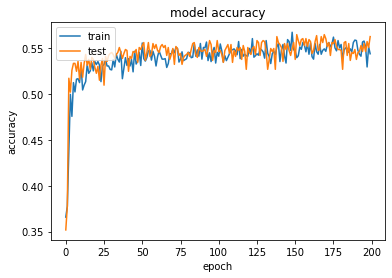

88/88 [==============================] - 0s 2ms/step - loss: 0.8333 - accuracy: 0.5624 - recall_m: 0.2718 - precision_m: 0.7230 - f1_m: 0.3913


In [82]:

modelc = build_classification_model(train_cx, train_cy)
#預測test
pred_cy = modelc.predict(test_cx)
evaluate_cy = modelc.evaluate(train_cx,train_cy,verbose = 1)
#預測train
pred_train_train_cy = modelc.predict(train_cx)
evaluate_train_cy = modelc.evaluate(train_cx,train_cy,verbose = 1)


In [83]:
pred_train_train_cy

array([[0.44480833, 0.06124178, 0.49394992],
       [0.13634998, 0.6821938 , 0.18145618],
       [0.15037748, 0.6410569 , 0.20856564],
       ...,
       [0.32489806, 0.21665573, 0.45844617],
       [0.42654726, 0.08107157, 0.4923811 ],
       [0.03477111, 0.92043996, 0.044789  ]], dtype=float32)

In [84]:
train_cx

array([[0.71621622, 0.73109244, 0.13274336, ..., 0.3475971 , 0.29247633,
        9.        ],
       [0.58783784, 0.57142857, 0.09292035, ..., 0.16655695, 0.16292975,
        8.        ],
       [0.64189189, 0.58823529, 0.11061947, ..., 0.1797235 , 0.19780767,
        9.        ],
       ...,
       [0.7027027 , 0.68067227, 0.13274336, ..., 0.25279789, 0.2326856 ,
        8.        ],
       [0.74324324, 0.73109244, 0.15486726, ..., 0.28439763, 0.35675137,
        8.        ],
       [0.45945946, 0.47058824, 0.08849558, ..., 0.0875576 , 0.10313901,
        7.        ]])

In [85]:
train_cy

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [86]:
# train_cy2 = train_cy.copy()
# train_cy2 = train_cy2.values
# train_cy2 = [float(train_cy2[i]) for i in range(len(train_cy2))]
#模型結果績效
# pred_cy = pred_cy.flatten()
# test_cy = test_cy.flatten()

#test 績效
precision = precision_m(test_cy, pred_cy)
recall = recall_m(test_cy, pred_cy)
f1 = f1_m(test_cy, pred_cy)
print(f'我是TEST : precision:{precision}, recall:{recall}, f1:{f1}')

#train 績效
precision = precision_m(train_cy, pred_train_train_cy)
recall = recall_m(train_cy, pred_train_train_cy)
f1 = f1_m(train_cy, pred_train_train_cy)
print(f'我是Tarin :precision:{precision}, recall:{recall}, f1:{f1}')

我是TEST : precision:0.7156862616539001, recall:0.2646845579147339, f1:0.38644781708717346
我是Tarin :precision:0.7241706252098083, recall:0.2731498181819916, f1:0.39667701721191406
